<a href="https://colab.research.google.com/github/rmehdi1/CommunityProject_Mobilize/blob/main/02_Analysis_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install textstat

In [15]:
from sklearn.preprocessing import LabelEncoder

# LOAD DATA & QUALITY CHECK

In [16]:
# Change.org Petition Analysis: Success Pattern Discovery
# Enhanced Text Analytics & Predictive Modeling for MobilizeNow
# This analysis examines 3,081 Change.org petitions to identify messaging and engagement patterns

# ============================================================================
# PART 1: SETUP AND DATA LOADING
# ============================================================================

# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import string
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Text processing libraries
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from textstat import flesch_reading_ease, flesch_kincaid_grade
try:
    from textstat import gunning_fog, automated_readability_index
except ImportError:
    print("Advanced readability metrics not available - using basic metrics only")
    def gunning_fog(text): return 0
    def automated_readability_index(text): return 0

from wordcloud import WordCloud

# Download required NLTK data
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Load the preprocessed dataset
# Replace this path with your actual data file path
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Colab data/MobilizeNow/changeorg_preprocessed.csv')

print("="*60)
print("CHANGE.ORG PETITION ANALYSIS SETUP")
print("="*60)
print(f"Dataset loaded successfully")
print(f"Shape: {df.shape}")
print(f"Columns: {df.shape[1]}")
print(f"Rows: {df.shape[0]}")

# ============================================================================
# PART 2: DATA VALIDATION & QUALITY ASSESSMENT
# ============================================================================

print("\n" + "="*60)
print("DATA VALIDATION & QUALITY ASSESSMENT")
print("="*60)

# Basic dataset information
print(f"Dataset shape: {df.shape}")
print(f"Total petitions: {len(df):,}")
print(f"Total features: {df.shape[1]}")

# Target variable validation
if 'target_success' in df.columns:
    success_rate = df['target_success'].mean()
    success_count = df['target_success'].sum()
    print(f"\nTarget Variable Validation:")
    print(f"Success rate: {success_rate:.1%} ({success_count:,} successful petitions)")
    print(f"Class balance: {(1-success_rate):.1%} unsuccessful / {success_rate:.1%} successful")

    # Success pathway breakdown
    print(f"\nSuccess Pathway Analysis:")
    if 'is_victory' in df.columns:
        official_victories = df['is_victory'].sum()
        print(f"Official victories: {official_victories} ({official_victories/len(df):.1%})")

    # Calculate high efficiency and high scale thresholds
    if 'signatures_per_day' in df.columns:
        high_efficiency = (df['signatures_per_day'] >= df['signatures_per_day'].quantile(0.80)).sum()
        print(f"High efficiency (top 20%): {high_efficiency} ({high_efficiency/len(df):.1%})")

    if 'total_signature_count' in df.columns:
        high_scale = (df['total_signature_count'] >= df['total_signature_count'].quantile(0.80)).sum()
        print(f"High scale (top 20%): {high_scale} ({high_scale/len(df):.1%})")

# Missing data assessment
print(f"\nMISSING DATA ASSESSMENT:")
print("-" * 40)
total_missing = df.isnull().sum()
missing_pct = (total_missing / len(df)) * 100
missing_summary = pd.DataFrame({
    'Missing_Count': total_missing,
    'Missing_Percentage': missing_pct
})

missing_data = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
if len(missing_data) > 0:
    print("Variables with missing data:")
    print(missing_data.head(10))
else:
    print("No missing values detected in dataset")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CHANGE.ORG PETITION ANALYSIS SETUP
Dataset loaded successfully
Shape: (3081, 42)
Columns: 42
Rows: 3081

DATA VALIDATION & QUALITY ASSESSMENT
Dataset shape: (3081, 42)
Total petitions: 3,081
Total features: 42

Target Variable Validation:
Success rate: 23.2% (715 successful petitions)
Class balance: 76.8% unsuccessful / 23.2% successful

Success Pathway Analysis:
Official victories: 119 (3.9%)
High efficiency (top 20%): 617 (20.0%)
High scale (top 20%): 617 (20.0%)

MISSING DATA ASSESSMENT:
----------------------------------------
Variables with missing data:
              Missing_Count  Missing_Percentage
victory_date           2962           96.137618
end_date               1442           46.802986
lat                     314           10.191496
long                    314           10.191496


# FEATURE DISTRIBUTION ANALYSIS


FEATURE DISTRIBUTION ANALYSIS
PERFORMANCE METRICS SUMMARY:
----------------------------------------

signatures_per_day:
 Range: 0.01 to 2701.40
 Median: 0.23
 Mean: 12.09
 Skewness: 18.41

signatures_per_view:
 Range: 0.03 to 800000000.00
 Median: 0.26
 Mean: 421942.02
 Skewness: 42.10

duration_days:
 Range: 1.00 to 4137.00
 Median: 365.00
 Mean: 391.07
 Skewness: 7.77

ACTIVITY PATTERNS SUMMARY:
----------------------------------------
has_daily_activity: 11.7% of petitions show this activity
has_weekly_activity: 28.6% of petitions show this activity
has_monthly_activity: 55.1% of petitions show this activity


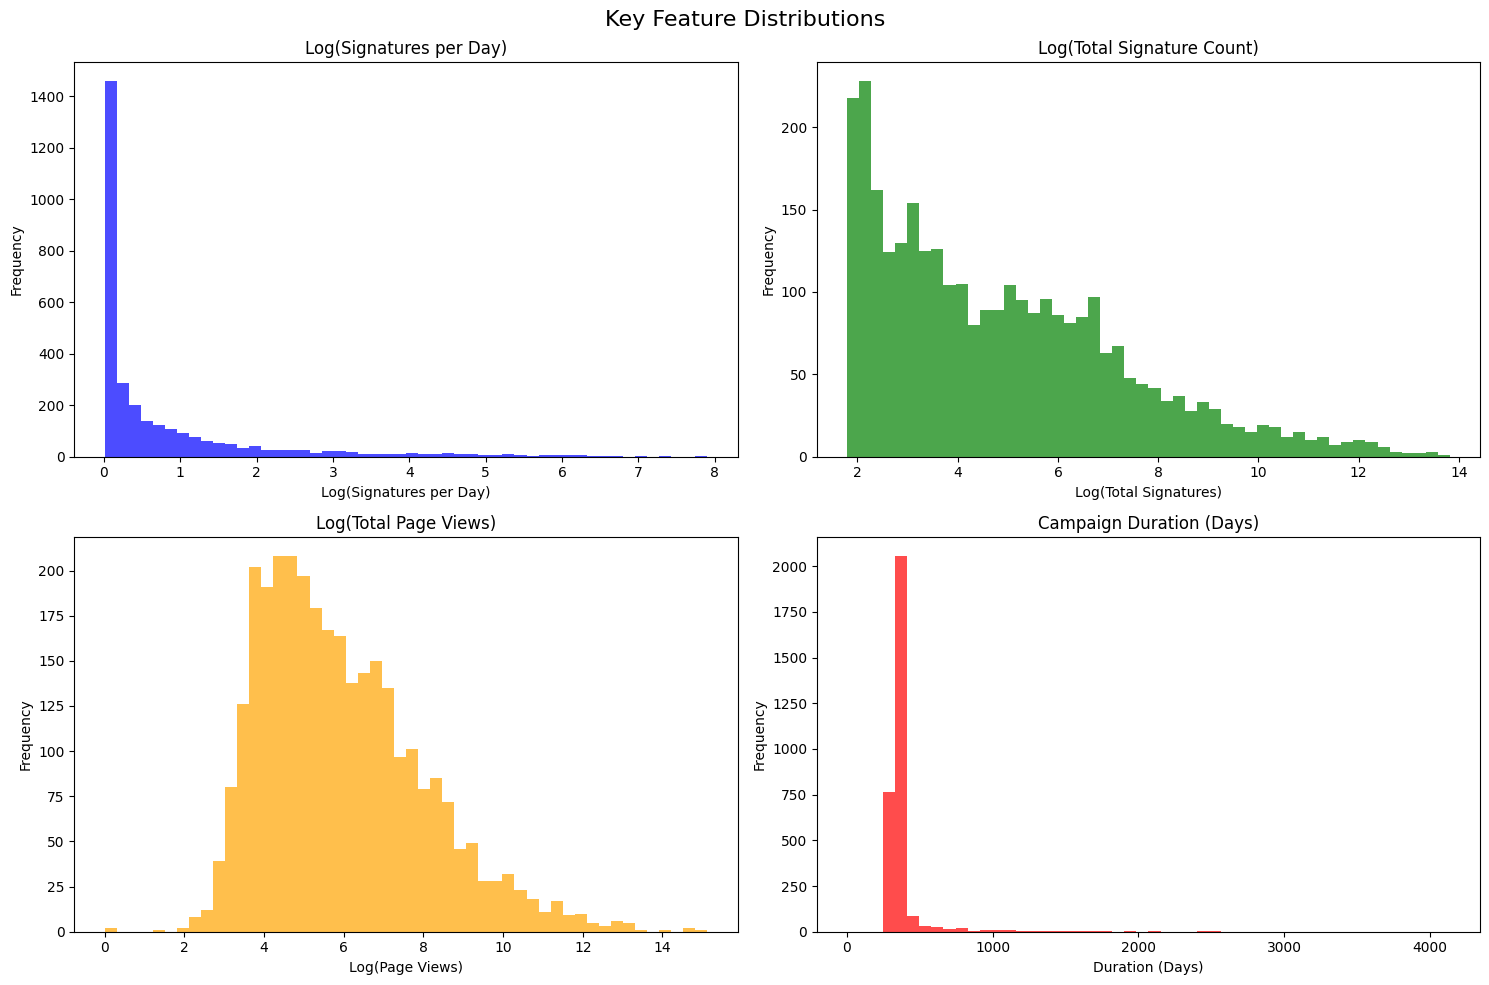

In [17]:



# ============================================================================
# PART 3: FEATURE DISTRIBUTION ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("FEATURE DISTRIBUTION ANALYSIS")
print("="*60)

# Define key features for analysis
performance_metrics = ['signatures_per_day', 'signatures_per_view', 'duration_days']
engagement_metrics = ['total_signature_count', 'total_page_views']
activity_flags = ['has_daily_activity', 'has_weekly_activity', 'has_monthly_activity']

# Performance metrics analysis
print("PERFORMANCE METRICS SUMMARY:")
print("-" * 40)
for metric in performance_metrics:
    if metric in df.columns:
        stats_summary = df[metric].describe()
        skewness = df[metric].skew()
        print(f"\n{metric}:")
        print(f" Range: {stats_summary['min']:.2f} to {stats_summary['max']:.2f}")
        print(f" Median: {stats_summary['50%']:.2f}")
        print(f" Mean: {stats_summary['mean']:.2f}")
        print(f" Skewness: {skewness:.2f}")

# Activity patterns analysis
print(f"\nACTIVITY PATTERNS SUMMARY:")
print("-" * 40)
for activity in activity_flags:
    if activity in df.columns:
        activity_rate = df[activity].mean()
        print(f"{activity}: {activity_rate:.1%} of petitions show this activity")

# Create distribution visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Key Feature Distributions', fontsize=16)

# Plot distributions for key metrics
if 'signatures_per_day' in df.columns:
    axes[0,0].hist(np.log1p(df['signatures_per_day']), bins=50, alpha=0.7, color='blue')
    axes[0,0].set_title('Log(Signatures per Day)')
    axes[0,0].set_xlabel('Log(Signatures per Day)')
    axes[0,0].set_ylabel('Frequency')

if 'total_signature_count' in df.columns:
    axes[0,1].hist(np.log1p(df['total_signature_count']), bins=50, alpha=0.7, color='green')
    axes[0,1].set_title('Log(Total Signature Count)')
    axes[0,1].set_xlabel('Log(Total Signatures)')
    axes[0,1].set_ylabel('Frequency')

if 'total_page_views' in df.columns:
    axes[1,0].hist(np.log1p(df['total_page_views']), bins=50, alpha=0.7, color='orange')
    axes[1,0].set_title('Log(Total Page Views)')
    axes[1,0].set_xlabel('Log(Page Views)')
    axes[1,0].set_ylabel('Frequency')

if 'duration_days' in df.columns:
    axes[1,1].hist(df['duration_days'], bins=50, alpha=0.7, color='red')
    axes[1,1].set_title('Campaign Duration (Days)')
    axes[1,1].set_xlabel('Duration (Days)')
    axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Bivariate Analysis

In [18]:


# ============================================================================
# PART 4: BIVARIATE ANALYSIS - CATEGORICAL VARIABLES
# ============================================================================

from scipy.stats import chi2_contingency, mannwhitneyu

print("\n" + "="*60)
print("BIVARIATE ANALYSIS: CATEGORICAL VARIABLES")
print("="*60)

# Define categorical variables for analysis
categorical_vars = [
    'petition_status', 'is_victory', 'is_verified_victory', 'is_pledge',
    'sponsored_campaign', 'hide_comments', 'hide_dm_action_panel',
    'enable_human_verification', 'original_locale', 'has_location',
    'is_active', 'has_end_date', 'has_daily_activity', 'has_weekly_activity',
    'has_monthly_activity'
]

# Filter to existing columns
existing_categorical = [var for var in categorical_vars if var in df.columns]
print("Categorical Variable Analysis:")
print("Variable".ljust(25) + "Chi-square".ljust(12) + "p-value".ljust(12) + "Significant".ljust(12) + "Success Rate Diff")
print("-" * 80)

categorical_results = {}
for var in existing_categorical:
    if 'target_success' in df.columns:
        # Create contingency table
        contingency_table = pd.crosstab(df[var], df['target_success'])

        # Chi-square test
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)

        # Success rates by category
        success_rates = df.groupby(var)['target_success'].mean()
        success_rate_diff = success_rates.max() - success_rates.min()

        # Statistical significance
        is_significant = "Yes" if p_value < 0.05 else "No"

        # Store results
        categorical_results[var] = {
            'chi2': chi2,
            'p_value': p_value,
            'significant': is_significant,
            'success_rate_diff': success_rate_diff,
            'success_rates': success_rates
        }

        # Print summary
        print(f"{var[:24].ljust(25)}{chi2:.2f}".ljust(12) +
              f"{p_value:.4f}".ljust(12) +
              f"{is_significant}".ljust(12) +
              f"{success_rate_diff:.1%}")

# Identify most significant categorical predictors
significant_categorical = {k: v for k, v in categorical_results.items() if v['p_value'] < 0.05}
print(f"\nSIGNIFICANT CATEGORICAL PREDICTORS: {len(significant_categorical)}")
for var in sorted(significant_categorical.keys(), key=lambda x: categorical_results[x]['p_value']):
    print(f" {var}: p-value = {categorical_results[var]['p_value']:.4f}")

# ============================================================================
# PART 5: BIVARIATE ANALYSIS - NUMERICAL VARIABLES
# ============================================================================

print("\n" + "="*60)
print("BIVARIATE ANALYSIS: NUMERICAL VARIABLES")
print("="*60)

# Define numerical variables for analysis
numerical_vars = [
    'total_signature_count', 'total_page_views', 'signatures_per_day',
    'signatures_per_view', 'views_per_signature', 'duration_days',
    'recent_weekly_momentum', 'recent_monthly_momentum', 'progress'
]

# Filter to existing columns
existing_numerical = [var for var in numerical_vars if var in df.columns]
print("Numerical Variable Analysis:")
print("Variable".ljust(25) + "Unsuccessful Med".ljust(16) + "Successful Med".ljust(16) +
      "p-value".ljust(12) + "Correlation".ljust(12) + "Significant")
print("-" * 95)

numerical_results = {}
for var in existing_numerical:
    if 'target_success' in df.columns:
        # Split by success status
        unsuccessful = df[df['target_success'] == 0][var].dropna()
        successful = df[df['target_success'] == 1][var].dropna()

        # Mann-Whitney U test
        if len(unsuccessful) > 0 and len(successful) > 0:
            statistic, p_value = mannwhitneyu(unsuccessful, successful, alternative='two-sided')

            # Correlation with success
            correlation = df[var].corr(df['target_success'])

            # Medians
            unsuccessful_median = unsuccessful.median()
            successful_median = successful.median()

            # Statistical significance
            is_significant = "Yes" if p_value < 0.05 else "No"

            # Store results
            numerical_results[var] = {
                'unsuccessful_median': unsuccessful_median,
                'successful_median': successful_median,
                'p_value': p_value,
                'correlation': correlation,
                'significant': is_significant
            }

            # Print summary
            print(f"{var[:24].ljust(25)}{unsuccessful_median:.2f}".ljust(16) +
                  f"{successful_median:.2f}".ljust(16) +
                  f"{p_value:.4f}".ljust(12) +
                  f"{correlation:.4f}".ljust(12) +
                  f"{is_significant}")

# Identify strongest numerical predictors
significant_numerical = {k: v for k, v in numerical_results.items() if v['p_value'] < 0.05}
print(f"\nSTRONGEST NUMERICAL PREDICTORS (by correlation):")
sorted_by_correlation = sorted(significant_numerical.items(), key=lambda x: abs(x[1]['correlation']), reverse=True)
for var, stats in sorted_by_correlation[:5]:
    print(f" {var}: r = {stats['correlation']:.4f}, p = {stats['p_value']:.4f}")




BIVARIATE ANALYSIS: CATEGORICAL VARIABLES
Categorical Variable Analysis:
Variable                 Chi-square  p-value     Significant Success Rate Diff
--------------------------------------------------------------------------------
petition_status          409.600.0000      Yes         80.0%
is_victory               405.130.0000      Yes         79.9%
is_verified_victory      3.010.0826      No          76.8%
is_pledge                0.001.0000      No          0.0%
sponsored_campaign       0.001.0000      No          0.0%
hide_comments            0.001.0000      No          1.8%
hide_dm_action_panel     0.001.0000      No          0.0%
enable_human_verificatio 3.010.0826      No          76.8%
original_locale          40.020.0000      Yes         100.0%
has_location             14.110.0002      Yes         9.6%
is_active                27.350.0000      Yes         8.0%
has_end_date             27.350.0000      Yes         8.0%
has_daily_activity       131.400.0000      Yes         2

# SUCCESS PATTERN ANLAYSIS

In [19]:
# ============================================================================
# PART 6: SUCCESS PATTERN DEEP DIVE
# ============================================================================

print("\n" + "="*60)
print("SUCCESS PATTERN DEEP DIVE")
print("="*60)

if 'target_success' in df.columns:
    # Success pathway overlap analysis
    print("SUCCESS PATHWAY OVERLAP ANALYSIS:")
    print("-" * 40)

    # Define success pathways
    if all(col in df.columns for col in ['is_victory', 'signatures_per_day', 'total_signature_count']):
        is_official_victory = df['is_victory']
        is_high_efficiency = df['signatures_per_day'] >= df['signatures_per_day'].quantile(0.80)
        is_high_scale = df['total_signature_count'] >= df['total_signature_count'].quantile(0.80)

        # Calculate overlaps
        victory_only = is_official_victory & ~is_high_efficiency & ~is_high_scale
        efficiency_only = ~is_official_victory & is_high_efficiency & ~is_high_scale
        scale_only = ~is_official_victory & ~is_high_efficiency & is_high_scale
        multiple_pathways = (is_official_victory.astype(int) + is_high_efficiency.astype(int) + is_high_scale.astype(int)) > 1

        print(f"Victory only: {victory_only.sum()} ({victory_only.mean():.1%})")
        print(f"Efficiency only: {efficiency_only.sum()} ({efficiency_only.mean():.1%})")
        print(f"Scale only: {scale_only.sum()} ({scale_only.mean():.1%})")
        print(f"Multiple pathways: {multiple_pathways.sum()} ({multiple_pathways.mean():.1%})")

    # Performance profiles
    print(f"\nPERFORMANCE PROFILES:")
    print("-" * 40)

    successful_petitions = df[df['target_success'] == 1]
    unsuccessful_petitions = df[df['target_success'] == 0]

    key_metrics = ['signatures_per_day', 'total_signature_count', 'total_page_views', 'signatures_per_view', 'duration_days']
    for metric in key_metrics:
        if metric in df.columns:
            succ_median = successful_petitions[metric].median()
            unsucc_median = unsuccessful_petitions[metric].median()
            ratio = succ_median / unsucc_median if unsucc_median > 0 else float('inf')

            print(f"\n{metric}:")
            print(f" Successful median: {succ_median:.2f}")
            print(f" Unsuccessful median: {unsucc_median:.2f}")
            print(f" Success advantage: {ratio:.1f}x")

    # Activity pattern analysis
    print(f"\nACTIVITY PATTERN ANALYSIS:")
    print("-" * 40)
    activity_vars = ['has_daily_activity', 'has_weekly_activity', 'has_monthly_activity']
    for activity in activity_vars:
        if activity in df.columns:
            succ_rate = successful_petitions[activity].mean()
            unsucc_rate = unsuccessful_petitions[activity].mean()
            print(f"{activity}:")
            print(f" Successful petitions: {succ_rate:.1%}")
            print(f" Unsuccessful petitions: {unsucc_rate:.1%}")
            print(f" Difference: {succ_rate - unsucc_rate:+.1%}")





SUCCESS PATTERN DEEP DIVE
SUCCESS PATHWAY OVERLAP ANALYSIS:
----------------------------------------
Victory only: 72 (2.3%)
Efficiency only: 23 (0.7%)
Scale only: 26 (0.8%)
Multiple pathways: 594 (19.3%)

PERFORMANCE PROFILES:
----------------------------------------

signatures_per_day:
 Successful median: 7.25
 Unsuccessful median: 0.10
 Success advantage: 71.3x

total_signature_count:
 Successful median: 2978.00
 Unsuccessful median: 36.00
 Success advantage: 82.7x

total_page_views:
 Successful median: 4686.00
 Unsuccessful median: 155.00
 Success advantage: 30.2x

signatures_per_view:
 Successful median: 0.58
 Unsuccessful median: 0.23
 Success advantage: 2.6x

duration_days:
 Successful median: 369.00
 Unsuccessful median: 364.00
 Success advantage: 1.0x

ACTIVITY PATTERN ANALYSIS:
----------------------------------------
has_daily_activity:
 Successful petitions: 23.9%
 Unsuccessful petitions: 8.1%
 Difference: +15.8%
has_weekly_activity:
 Successful petitions: 43.4%
 Unsucces


### Performance Profiles

We analyze key campaign performance indicators across successful and unsuccessful groups:

- **Signatures per Day:** A 71x median difference confirms that sustained momentum is a defining feature of successful campaigns.
- **Total Signature Count:** Successful petitions attract vastly more support—an 83x difference in the median.
- **Page Views:** Successful petitions see broader visibility (30x higher median), though virality alone doesn’t guarantee success.
- **Conversion Rate (Signatures per View):** Even adjusting for traffic, successful petitions convert 2.6x more effectively.
- **Duration:** Campaign length shows **no meaningful difference**, challenging assumptions that longer duration drives success.

These metrics suggest that **early engagement and conversion efficiency** are more critical than campaign longevity.

---

### Activity Pattern Analysis

Engagement over time provides further signal:

- **Daily/Weekly Activity Presence:** Successful petitions are **2–3x more likely** to show frequent activity spikes, suggesting coordinated amplification or consistent attention.
- **Monthly Activity:** Sustained visibility still matters, with a 20.8% differential in long-tail engagement.

These trends emphasize that **success correlates with momentum**, not just end outcomes—supporting our modeling focus on early signals and structural features.


# TEXT DATA PREPARATION

In [26]:
# ============================================================================
# PART 7: TEXT DATA PREPARATION
# ============================================================================

print("\n" + "="*60)
print("TEXT ANALYTICS & MESSAGING PATTERN DISCOVERY")
print("="*60)

# Verify text columns exist and examine content
text_columns = ['title', 'description', 'letter_body', 'targeting_description']
available_text_cols = [col for col in text_columns if col in df.columns]
print(f"Available text columns: {available_text_cols}")
print(f"Total petitions for text analysis: {len(df):,}")

# Basic text data quality check
for col in available_text_cols:
    non_null_count = df[col].notna().sum()
    avg_length = df[col].str.len().mean()
    print(f"{col}: {non_null_count:,} non-null ({non_null_count/len(df):.1%}), avg length: {avg_length:.0f} chars")

# Sample successful vs unsuccessful titles for initial inspection
if 'target_success' in df.columns and 'title' in available_text_cols:
    print(f"\nSAMPLE SUCCESSFUL PETITION TITLES:")
    print("-" * 40)
    successful_sample = df[df['target_success'] == 1]['title'].sample(min(5, len(df[df['target_success'] == 1])), random_state=42)
    for i, title in enumerate(successful_sample, 1):
        print(f"{i}. {title[:100]}...")

    print(f"\nSAMPLE UNSUCCESSFUL PETITION TITLES:")
    print("-" * 40)
    unsuccessful_sample = df[df['target_success'] == 0]['title'].sample(min(5, len(df[df['target_success'] == 0])), random_state=42)
    for i, title in enumerate(unsuccessful_sample, 1):
        print(f"{i}. {title[:100]}...")

# ============================================================================
# PART 8: ENHANCED TEXT PREPROCESSING FUNCTIONS
# ============================================================================

# Define comprehensive text analysis functions
def clean_html(text):
    """Remove HTML tags and clean text for analysis"""
    if pd.isna(text):
        return ""
    # Remove HTML tags
    clean = re.sub('<.*?>', '', str(text))
    # Remove extra whitespace
    clean = ' '.join(clean.split())
    return clean

def count_html_tags(text):
    """Count HTML formatting tags in text"""
    if pd.isna(text):
        return 0
    return len(re.findall('<.*?>', str(text)))

def safe_sent_tokenize(text):
    """Safe sentence tokenization with fallback"""
    try:
        return sent_tokenize(text)
    except:
        # Fallback: split on common sentence endings
        sentences = re.split(r'[.!?]+', text)
        return [s.strip() for s in sentences if s.strip()]

def safe_word_tokenize(text):
    """Safe word tokenization with fallback"""
    try:
        return word_tokenize(text)
    except:
        # Fallback: simple split
        return text.split()

def calculate_advanced_readability(text):
    """
    Calculate a variety of readability and text quality metrics
    to assess how easy or hard a piece of text is to read and understand.
    This helps us evaluate the linguistic complexity and communication style.
    """
    # Return zeroes if the text is empty or too short to analyze
    if pd.isna(text) or len(str(text).strip()) < 10:
        return {
            'flesch_ease': 0, 'flesch_kincaid': 0, 'gunning_fog': 0,
            'automated_readability': 0, 'avg_sentence_length': 0,
            'avg_word_length': 0, 'vocab_diversity': 0, 'caps_ratio': 0
        }

    # First, clean the text by removing HTML tags and extra whitespace
    clean_text = clean_html(text)

    try:
        # Flesch Reading Ease: higher is easier to read (e.g., 60+ is fairly easy)
        flesch_ease = flesch_reading_ease(clean_text)

        # Flesch-Kincaid Grade Level: U.S. school grade level needed to understand the text
        flesch_kincaid = flesch_kincaid_grade(clean_text)

        # Gunning Fog Index: estimates years of formal education needed to understand the text
        gunning_fog_score = gunning_fog(clean_text)

        # Automated Readability Index: another grade-level metric, considers characters per word and words per sentence
        automated_readability = automated_readability_index(clean_text)

    except:
        # If any metric fails to compute, fall back to zero
        flesch_ease = flesch_kincaid = gunning_fog_score = automated_readability = 0

    try:
        # Split text into sentences and words (safely handles bad formatting)
        sentences = safe_sent_tokenize(clean_text)
        words = safe_word_tokenize(clean_text)

        # Average number of words per sentence – longer sentences are often harder to read
        avg_sentence_length = len(words) / len(sentences) if sentences else 0

        # Average number of letters per word – longer words often indicate complexity
        avg_word_length = sum(len(word) for word in words) / len(words) if words else 0

        # Vocabulary diversity – measures uniqueness of words used (higher is more diverse)
        unique_words = set(word.lower() for word in words if word.isalpha())
        vocab_diversity = len(unique_words) / len(words) if words else 0

        # CAPS ratio – measures how much text is in ALL CAPS, which may signal shouting or emphasis
        caps_words = sum(1 for word in words if word.isupper() and len(word) > 1)
        caps_ratio = caps_words / len(words) if words else 0

    except:
        # If structure analysis fails, use safe defaults
        avg_sentence_length = avg_word_length = vocab_diversity = caps_ratio = 0

    return {
        'flesch_ease': flesch_ease,
        'flesch_kincaid': flesch_kincaid,
        'gunning_fog': gunning_fog_score,
        'automated_readability': automated_readability,
        'avg_sentence_length': avg_sentence_length,
        'avg_word_length': avg_word_length,
        'vocab_diversity': vocab_diversity,
        'caps_ratio': caps_ratio
    }

def count_keywords(text, keywords):
    """
    Count how many times any of the given keywords appear in the text.
    This helps assess emphasis on key terms like urgency, action, emotion, etc.
    """
    if pd.isna(text):
        return 0

    # Clean text of HTML and convert to lowercase for fair matching
    clean_text = clean_html(text).lower()

    count = 0
    for keyword in keywords:
        count += clean_text.count(keyword.lower())

    return count

print("Text preprocessing functions defined successfully")




TEXT ANALYTICS & MESSAGING PATTERN DISCOVERY
Available text columns: ['title', 'description', 'letter_body', 'targeting_description']
Total petitions for text analysis: 3,081
title: 3,081 non-null (100.0%), avg length: 78 chars
description: 3,081 non-null (100.0%), avg length: 1515 chars
letter_body: 3,081 non-null (100.0%), avg length: 160 chars
targeting_description: 3,081 non-null (100.0%), avg length: 55 chars

SAMPLE SUCCESSFUL PETITION TITLES:
----------------------------------------
1. MANDATORY INSTALLATION OF OXYGEN PLANT IN ALL HOSPITALS ABOVE 50 BEDS...
2. Ravi Shankar Prasad : Death Penalty for Rapist within a month...
3. Clean Up Bengaluru @Yediyurappa...
4. PM office: Stop defaming Ayurveda surgeons that they less qualified and untrained...
5. Arvind Kejriwal: Cap Covid 19 treatment charges in Delhi private hospitals...

SAMPLE UNSUCCESSFUL PETITION TITLES:
----------------------------------------
1. Ministry of civil aviation, India. : Sequential deboarding on domestic 

# TEXT ANALYTICS

 ## CONTENT LENGTH AND STRUCTURE ANALYSIS


CONTENT STRUCTURE & LENGTH ANALYSIS
CONTENT LENGTH ANALYSIS:
----------------------------------------

TITLE:
 Successful median length: 83 characters
 Unsuccessful median length: 70 characters
 Success advantage: 1.19x
 Successful mean words: 13
 Unsuccessful mean words: 12

DESCRIPTION:
 Successful median length: 1511 characters
 Unsuccessful median length: 914 characters
 Success advantage: 1.65x
 Successful mean words: 339
 Unsuccessful mean words: 203

LETTER_BODY:
 Successful median length: 66 characters
 Unsuccessful median length: 48 characters
 Success advantage: 1.38x
 Successful mean words: 55
 Unsuccessful mean words: 17

TARGETING_DESCRIPTION:
 Successful median length: 51 characters
 Unsuccessful median length: 35 characters
 Success advantage: 1.46x
 Successful mean words: 9
 Unsuccessful mean words: 7

HTML FORMATTING ANALYSIS:
----------------------------------------
Successful petitions - avg HTML tags: 28.8
Unsuccessful petitions - avg HTML tags: 14.2
HTML formattin

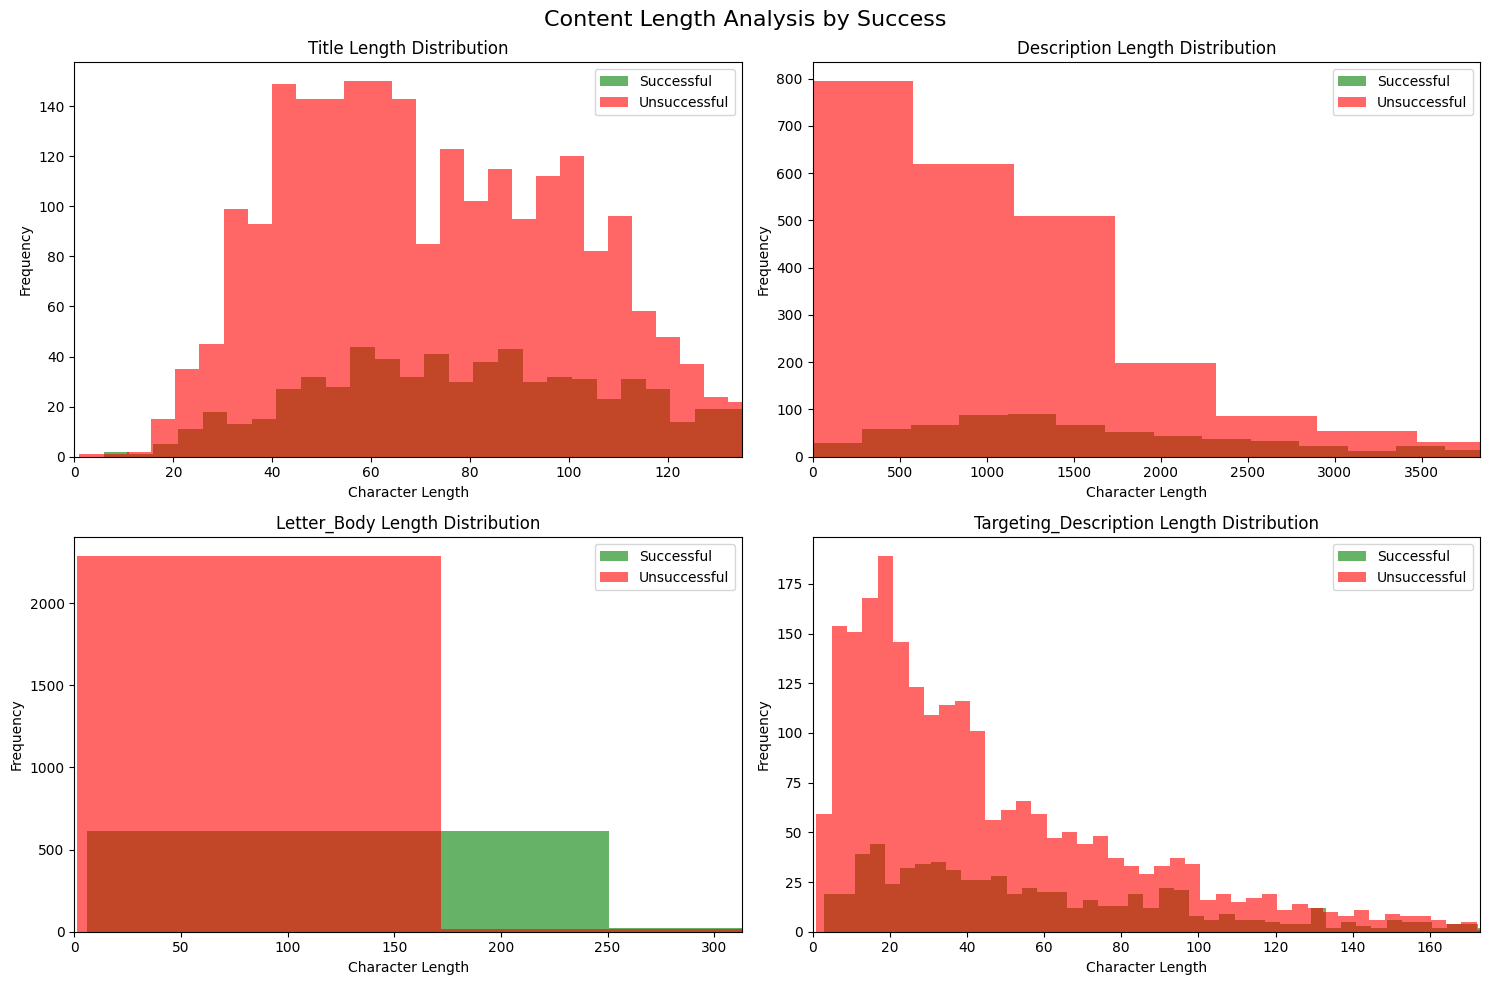

In [21]:

print("\n" + "="*60)
print("CONTENT STRUCTURE & LENGTH ANALYSIS")
print("="*60)

# Analyze content length patterns
print("CONTENT LENGTH ANALYSIS:")
print("-" * 40)

length_analysis = {}
for col in available_text_cols:
    # Calculate lengths
    df[f'{col}_length'] = df[col].str.len().fillna(0)
    df[f'{col}_clean_length'] = df[col].apply(clean_html).str.len()
    df[f'{col}_word_count'] = df[col].apply(clean_html).str.split().str.len().fillna(0)

    if col == 'description':
        df[f'{col}_html_tags'] = df[col].apply(count_html_tags)

    if 'target_success' in df.columns:
        # Compare successful vs unsuccessful
        successful_lengths = df[df['target_success'] == 1][f'{col}_clean_length']
        unsuccessful_lengths = df[df['target_success'] == 0][f'{col}_clean_length']

        # Store analysis results
        length_analysis[col] = {
            'successful_median': successful_lengths.median(),
            'unsuccessful_median': unsuccessful_lengths.median(),
            'successful_mean': successful_lengths.mean(),
            'unsuccessful_mean': unsuccessful_lengths.mean(),
            'advantage_ratio': successful_lengths.median() / unsuccessful_lengths.median() if unsuccessful_lengths.median() > 0 else float('inf')
        }

        print(f"\n{col.upper()}:")
        print(f" Successful median length: {successful_lengths.median():.0f} characters")
        print(f" Unsuccessful median length: {unsuccessful_lengths.median():.0f} characters")
        print(f" Success advantage: {length_analysis[col]['advantage_ratio']:.2f}x")
        print(f" Successful mean words: {df[df['target_success'] == 1][f'{col}_word_count'].mean():.0f}")
        print(f" Unsuccessful mean words: {df[df['target_success'] == 0][f'{col}_word_count'].mean():.0f}")

# HTML formatting analysis for descriptions
if 'description' in available_text_cols and 'target_success' in df.columns:
    print(f"\nHTML FORMATTING ANALYSIS:")
    print("-" * 40)
    successful_html = df[df['target_success'] == 1]['description_html_tags']
    unsuccessful_html = df[df['target_success'] == 0]['description_html_tags']
    print(f"Successful petitions - avg HTML tags: {successful_html.mean():.1f}")
    print(f"Unsuccessful petitions - avg HTML tags: {unsuccessful_html.mean():.1f}")
    print(f"HTML formatting advantage: {successful_html.mean() / unsuccessful_html.mean():.2f}x")

# Optimal length analysis
if 'title' in available_text_cols and 'target_success' in df.columns:
    print(f"\nOPTIMAL LENGTH ANALYSIS:")
    print("-" * 40)
    df['title_length_quartile'] = pd.qcut(df['title_clean_length'], q=4, labels=['Short', 'Medium-Short', 'Medium-Long', 'Long'])
    title_length_success = df.groupby('title_length_quartile')['target_success'].agg(['count', 'mean'])
    title_length_success.columns = ['Total_Petitions', 'Success_Rate']
    title_length_success['Success_Rate'] *= 100
    print("TITLE LENGTH vs SUCCESS RATE:")
    print(title_length_success.round(1))

    best_quartile = title_length_success['Success_Rate'].idxmax()
    print(f"\nOptimal title length: {best_quartile} quartile")

# Visualize length distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Content Length Analysis by Success', fontsize=16)

if 'target_success' in df.columns:
    for idx, col in enumerate(available_text_cols[:4]):
        row, col_idx = idx // 2, idx % 2

        if f'{col}_clean_length' in df.columns:
            successful_lengths = df[df['target_success'] == 1][f'{col}_clean_length']
            unsuccessful_lengths = df[df['target_success'] == 0][f'{col}_clean_length']

            axes[row, col_idx].hist(successful_lengths, bins=50, alpha=0.6, label='Successful', color='green')
            axes[row, col_idx].hist(unsuccessful_lengths, bins=50, alpha=0.6, label='Unsuccessful', color='red')
            axes[row, col_idx].set_title(f'{col.title()} Length Distribution')
            axes[row, col_idx].set_xlabel('Character Length')
            axes[row, col_idx].set_ylabel('Frequency')
            axes[row, col_idx].legend()
            axes[row, col_idx].set_xlim(0, df[f'{col}_clean_length'].quantile(0.95))

plt.tight_layout()
plt.show()

## SENTIMENT ANLAYSIS


SENTIMENT & EMOTIONAL TONE ANALYSIS

SENTIMENT ANALYSIS: TITLE
----------------------------------------
Successful petitions - avg sentiment: -0.012
Unsuccessful petitions - avg sentiment: -0.022
Sentiment difference: 0.010

SUCCESS RATES BY SENTIMENT CATEGORY:
 Negative: 22.5% success rate (1,107 petitions)
 Neutral: 22.9% success rate (987 petitions)
 Positive: 24.3% success rate (987 petitions)
Emotional intensity - Successful: 0.213, Unsuccessful: 0.221

SENTIMENT ANALYSIS: DESCRIPTION
----------------------------------------
Successful petitions - avg sentiment: 0.013
Unsuccessful petitions - avg sentiment: 0.003
Sentiment difference: 0.010

SUCCESS RATES BY SENTIMENT CATEGORY:
 Negative: 23.3% success rate (1,475 petitions)
 Neutral: 15.5% success rate (103 petitions)
 Positive: 23.7% success rate (1,503 petitions)
Emotional intensity - Successful: 0.196, Unsuccessful: 0.211

SENTIMENT ANALYSIS: LETTER_BODY
----------------------------------------
Successful petitions - avg sent

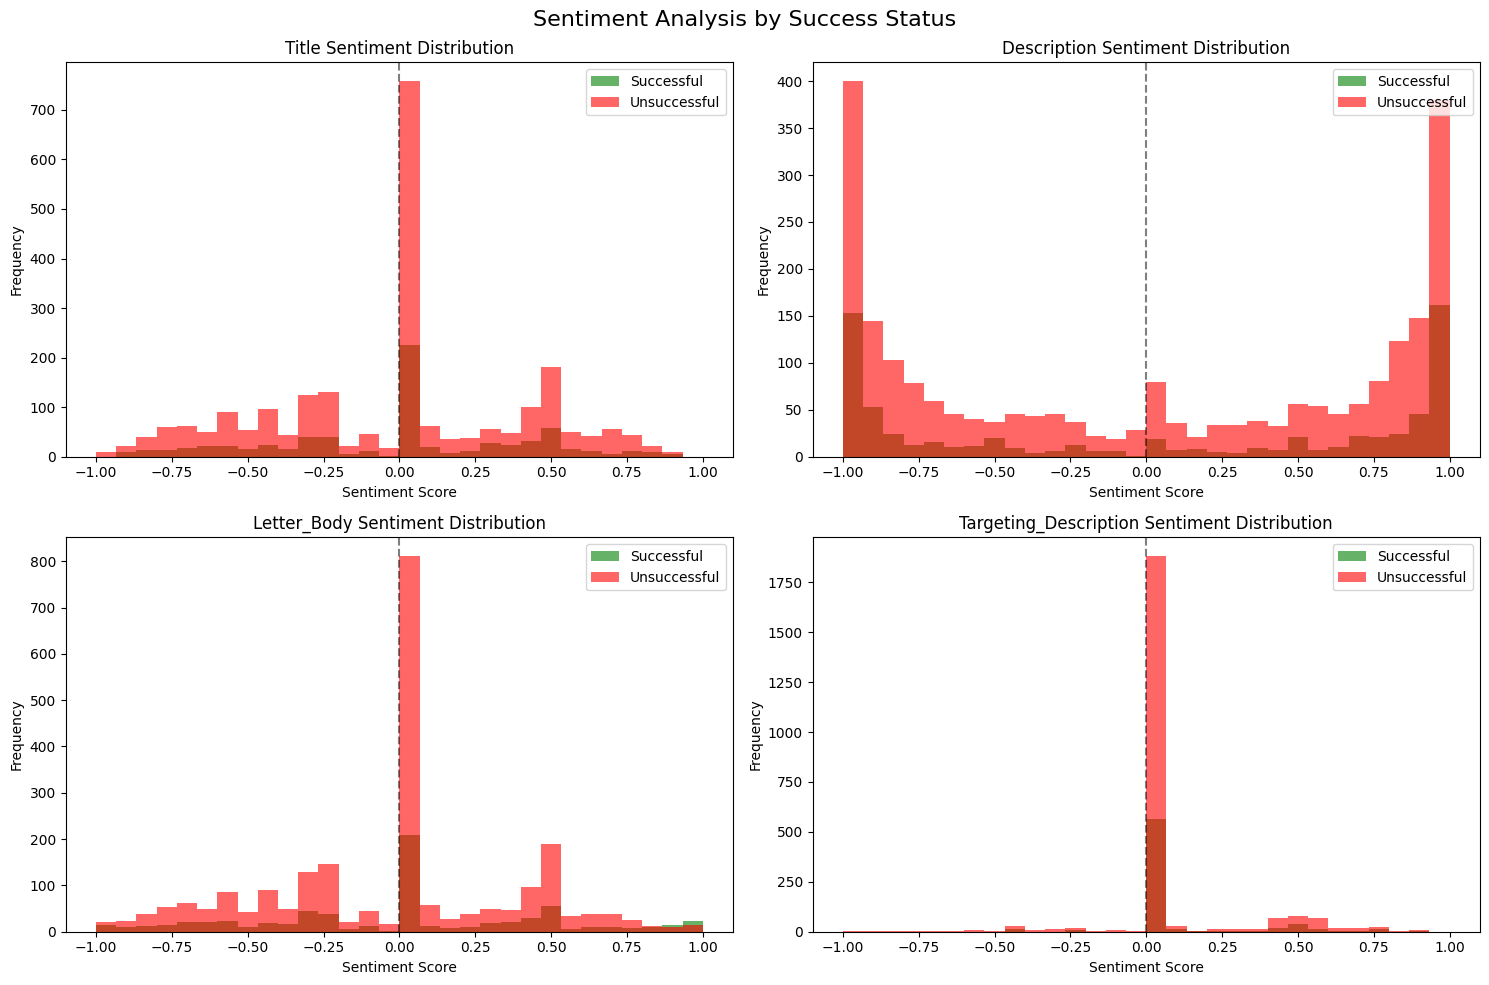

In [22]:


# ============================================================================
# PART 10:  SENTIMENT ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("SENTIMENT & EMOTIONAL TONE ANALYSIS")
print("="*60)

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    """Get comprehensive sentiment scores"""
    if pd.isna(text):
        return {'compound': 0, 'pos': 0, 'neg': 0, 'neu': 0}
    clean_text = clean_html(text)
    scores = sia.polarity_scores(clean_text)
    return scores

# Analyze sentiment across text components
sentiment_results = {}
for col in available_text_cols:
    print(f"\nSENTIMENT ANALYSIS: {col.upper()}")
    print("-" * 40)

    # Calculate sentiment scores
    sentiment_scores = df[col].apply(get_sentiment_scores)

    # Extract individual scores
    df[f'{col}_sentiment_compound'] = [score['compound'] for score in sentiment_scores]
    df[f'{col}_sentiment_positive'] = [score['pos'] for score in sentiment_scores]
    df[f'{col}_sentiment_negative'] = [score['neg'] for score in sentiment_scores]
    df[f'{col}_sentiment_neutral'] = [score['neu'] for score in sentiment_scores]

    # Categorize sentiment
    df[f'{col}_sentiment_category'] = df[f'{col}_sentiment_compound'].apply(
        lambda x: 'Positive' if x >= 0.05 else 'Negative' if x <= -0.05 else 'Neutral'
    )

    # Emotional intensity (sum of positive and negative scores)
    df[f'{col}_emotional_intensity'] = df[f'{col}_sentiment_positive'] + df[f'{col}_sentiment_negative']

    if 'target_success' in df.columns:
        # Compare successful vs unsuccessful
        successful_sentiment = df[df['target_success'] == 1][f'{col}_sentiment_compound']
        unsuccessful_sentiment = df[df['target_success'] == 0][f'{col}_sentiment_compound']

        print(f"Successful petitions - avg sentiment: {successful_sentiment.mean():.3f}")
        print(f"Unsuccessful petitions - avg sentiment: {unsuccessful_sentiment.mean():.3f}")
        print(f"Sentiment difference: {successful_sentiment.mean() - unsuccessful_sentiment.mean():.3f}")

        # Sentiment category distribution
        sentiment_success_rates = df.groupby(f'{col}_sentiment_category')['target_success'].mean() * 100

        print(f"\nSUCCESS RATES BY SENTIMENT CATEGORY:")
        for category in ['Negative', 'Neutral', 'Positive']:
            if category in sentiment_success_rates.index:
                rate = sentiment_success_rates[category]
                count = df[df[f'{col}_sentiment_category'] == category].shape[0]
                print(f" {category}: {rate:.1f}% success rate ({count:,} petitions)")

        # Store results
        sentiment_results[col] = {
            'successful_avg': successful_sentiment.mean(),
            'unsuccessful_avg': unsuccessful_sentiment.mean(),
            'success_rates_by_category': sentiment_success_rates
        }

        # Emotional intensity analysis
        successful_intensity = df[df['target_success'] == 1][f'{col}_emotional_intensity']
        unsuccessful_intensity = df[df['target_success'] == 0][f'{col}_emotional_intensity']
        print(f"Emotional intensity - Successful: {successful_intensity.mean():.3f}, Unsuccessful: {unsuccessful_intensity.mean():.3f}")

# Create sentiment visualization
if 'target_success' in df.columns and available_text_cols:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Sentiment Analysis by Success Status', fontsize=16)

    for idx, col in enumerate(available_text_cols[:4]):
        row, col_idx = idx // 2, idx % 2

        if f'{col}_sentiment_compound' in df.columns:
            successful_sentiment = df[df['target_success'] == 1][f'{col}_sentiment_compound']
            unsuccessful_sentiment = df[df['target_success'] == 0][f'{col}_sentiment_compound']

            axes[row, col_idx].hist(successful_sentiment, bins=30, alpha=0.6, label='Successful', color='green', range=(-1, 1))
            axes[row, col_idx].hist(unsuccessful_sentiment, bins=30, alpha=0.6, label='Unsuccessful', color='red', range=(-1, 1))
            axes[row, col_idx].set_title(f'{col.title()} Sentiment Distribution')
            axes[row, col_idx].set_xlabel('Sentiment Score')
            axes[row, col_idx].set_ylabel('Frequency')
            axes[row, col_idx].legend()
            axes[row, col_idx].axvline(x=0, color='black', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

## KEYWORD AND LANGUAGE ANALYSIS

In [23]:
# ============================================================================
# PART 11: KEYWORD AND LANGUAGE ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("ENHANCED KEYWORD & LANGUAGE ANALYSIS")
print("="*60)

"""
KEYWORD WEIGHTING METHODOLOGY:
Weights based on behavioral psychology research rather than data-driven optimization
to avoid target leakage during feature creation. Production systems could optimize
weights using only training data with cross-validation.

Research Foundation:
- Cialdini (2006): Influence principles (urgency=scarcity, social proof)
- Berger & Milkman (2012): Emotional contagion in viral content
- Digital marketing research: Urgency language effectiveness (HubSpot, 2023)
"""

# Enhanced keyword categories for comprehensive analysis
urgency_keywords = [
    'urgent', 'immediate', 'immediately', 'now', 'today', 'emergency', 'crisis',
    'deadline', 'time running out', "before it's too late", 'last chance',
    'act now', 'breaking', 'critical', 'asap', 'quickly', 'rapidly', 'soon',
    'time sensitive', 'expires', 'final notice', 'running out', 'running out of time',
    'closing soon', 'minutes left', 'hours left', 'act fast', 'clock is ticking',
    'urgent appeal', 'right away', "don't wait", 'rush', 'imminent'
]

action_keywords = [
    'stop', 'save', 'protect', 'demand', 'fight', 'defend', 'prevent',
    'ban', 'end', 'cancel', 'reverse', 'change', 'fix', 'solve',
    'help', 'support', 'join', 'sign', 'act', 'take action', 'make',
    'force', 'require', 'ensure', 'guarantee', 'implement', 'establish',
    'mandate', 'enforce', 'commit', 'pledge', 'promise', 'repeal',
    'prosecute', 'petition', 'regulate', 'authorize', 'decriminalize',
    'ratify', 'investigate', 'propose', 'suspend', 'intervene', 'urge',
    'ask', 'encourage', 'invite', 'participate', 'mobilize'
]

# New powerful keyword categories
power_words = [
    'justice', 'freedom', 'rights', 'equality', 'fair', 'unfair', 'wrong',
    'illegal', 'violation', 'abuse', 'corruption', 'scandal', 'outrage',
    'discrimination', 'injustice', 'betrayal', 'exploitation', 'oppression',
    'accountability', 'threat', 'dangerous', 'complicit', 'cover-up',
    'devastating', 'unjust', 'systemic', 'outrageous', 'unconscionable',
    'inexcusable', 'intolerable', 'unacceptable', 'shameful', 'historic',
    'unprecedented', 'groundbreaking', 'transformative'
]

authority_keywords = [
    'government', 'minister', 'ministry', 'department', 'authority', 'official',
    'court', 'judge', 'police', 'administration', 'commissioner', 'director',
    'secretary', 'chief', 'president', 'prime minister', 'governor', 'congress',
    'senate', 'parliament', 'agency', 'task force', 'ombudsman', 'representative',
    'lawmaker', 'mp', 'council', 'board of directors', 'ceo', 'executive',
    'chairman', 'superintendent', 'mayor', 'supervisor', 'inspector general',
    'attorney general'
]

specificity_keywords = [
    'million', 'thousand', 'billion', 'percent', '%', 'statistics', 'data',
    'study', 'research', 'report', 'evidence', 'facts', 'numbers', 'peer-reviewed',
    'metrics', 'surveys', 'benchmark', 'statistical', 'trend', 'projection', 'figures'
]

# New categories for enhanced analysis
social_proof_keywords = [
    'join thousands', 'others are signing', 'momentum building', 'growing movement',
    'people like you', 'your neighbors', 'community members', 'together we',
    'viral petition', 'everyone is signing', 'shared widely', 'trending now',
    'thousands have joined', 'massive response', 'popular support', 'join your neighbors',
    'be part of history'
]

emotional_keywords = [
    'heartbreaking', 'devastating', 'tragic', 'unthinkable', 'painful', 'outraged',
    'terrified', 'afraid', 'fear', 'anger', 'sad', 'hurt', 'helpless', 'shocked',
    'mourning', 'suffering', 'grief', 'heartbroken', 'in pain', 'crushed', 'violated',
    # Positive emotions for balance
    'hopeful', 'inspired', 'empowered', 'determined', 'passionate', 'proud',
    'excited', 'motivated'
]

# Enhanced CTA patterns for petition detection
cta_patterns = [
    # Direct action requests
    r'\bsign\s+this\b', r'\bsign\s+now\b', r'\bsign\s+the\s+petition\b',
    r'\bjoin\s+us\b', r'\bjoin\s+me\b', r'\bjoin\s+this\b', r'\bjoin\s+the\b',
    r'\bhelp\s+us\b', r'\bhelp\s+me\b', r'\bhelp\s+save\b', r'\bhelp\s+stop\b',
    r'\bsupport\s+this\b', r'\bsupport\s+us\b', r'\bsupport\s+me\b',
    # Action + urgency combinations
    r'\btake\s+action\b', r'\bact\s+now\b', r'\bact\s+today\b', r'\bact\s+immediately\b',
    r'\bmake\s+a\s+difference\b', r'\bmake\s+your\s+voice\s+heard\b',
    r'\bstand\s+with\b', r'\bstand\s+up\b', r'\bspeak\s+up\b',
    # Demand/petition language
    r'\bdemand\s+action\b', r'\bdemand\s+change\b', r'\bdemand\s+justice\b',
    r'\bstop\s+this\b', r'\bstop\s+them\b', r'\bend\s+this\b',
    r'\bforce\s+them\b', r'\bmake\s+them\b',
    # Petition-specific CTAs
    r'\badd\s+your\s+name\b', r'\badd\s+your\s+voice\b', r'\blend\s+your\s+voice\b',
    r'\bshow\s+your\s+support\b', r'\bvoice\s+your\s+support\b',
    r'\blet\s+them\s+know\b', r'\btell\s+them\b', r'\bsend\s+a\s+message\b',
    # Community building CTAs
    r'\btogether\s+we\s+can\b', r'\bwe\s+need\s+your\b', r'\byour\s+signature\b',
    r'\bevery\s+signature\b', r'\beach\s+signature\b', r'\byour\s+voice\s+matters\b',
    # Social sharing CTAs
    r'\bshare\s+this\b', r'\bspread\s+the\s+word\b', r'\btell\s+your\s+friends\b',
    r'\bshare\s+with\b', r'\bpass\s+it\s+on\b',
    # Imperative verbs (petition context)
    r'\bfight\s+for\b', r'\bfight\s+against\b', r'\bdefend\b', r'\bprotect\b',
    r'\bsave\b', r'\bprevent\b', r'\bchange\b', r'\bfix\b', r'\bsolve\b'
]

def calculate_enhanced_keyword_score(text, weights=None):
    """
We have set up the function for ease of user to change weightage of key words and focus on sepcific type of keywords, particularly if they want it to be psychology/behavioral based
    """


    if weights is None:
        weights = {
            'urgency': 1,
            'emotional': 1,
            'social_proof': 1,
            'power': 1,
            'action': 1,     #
            'authority': 1,  #
            'specificity': 1 # M
        }

    if pd.isna(text):
        return 0

    # Calculate weighted score
    score = (
        count_keywords(text, urgency_keywords) * weights['urgency'] +
        count_keywords(text, emotional_keywords) * weights['emotional'] +
        count_keywords(text, social_proof_keywords) * weights['social_proof'] +
        count_keywords(text, power_words) * weights['power'] +
        count_keywords(text, action_keywords) * weights['action'] +
        count_keywords(text, authority_keywords) * weights['authority'] +
        count_keywords(text, specificity_keywords) * weights['specificity']
    )
    return score

# Enhanced text analysis with multiple keyword categories and weighted scoring
for col in available_text_cols:
    print(f"\nENHANCED TEXT ANALYSIS: {col.upper()}")
    print("-" * 40)

    # Original keyword counts (for backward compatibility)
    df[f'{col}_urgency_count'] = df[col].apply(lambda x: count_keywords(x, urgency_keywords))
    df[f'{col}_action_count'] = df[col].apply(lambda x: count_keywords(x, action_keywords))
    df[f'{col}_has_urgency'] = df[f'{col}_urgency_count'] > 0
    df[f'{col}_has_action'] = df[f'{col}_action_count'] > 0

    # Enhanced keyword categories
    df[f'{col}_power_count'] = df[col].apply(lambda x: count_keywords(x, power_words))
    df[f'{col}_authority_count'] = df[col].apply(lambda x: count_keywords(x, authority_keywords))
    df[f'{col}_specificity_count'] = df[col].apply(lambda x: count_keywords(x, specificity_keywords))
    df[f'{col}_social_proof_count'] = df[col].apply(lambda x: count_keywords(x, social_proof_keywords))
    df[f'{col}_emotional_count'] = df[col].apply(lambda x: count_keywords(x, emotional_keywords))

    # Weighted strategic scoring (NEW FEATURE)
    df[f'{col}_weighted_keyword_score'] = df[col].apply(calculate_enhanced_keyword_score)

    # Call-to-action detection
    df[f'{col}_cta_count'] = df[col].apply(
        lambda x: sum(len(re.findall(pattern, str(x).lower())) for pattern in cta_patterns) if pd.notna(x) else 0
    )
    df[f'{col}_has_cta'] = (df[f'{col}_cta_count'] > 0).astype(int)

    # Numbers and statistics detection
    df[f'{col}_numbers_count'] = df[col].str.count(r'\d+').fillna(0)
    df[f'{col}_has_statistics'] = df[col].str.contains(
        r'\d+%|\d+\s*(percent|million|thousand|billion)', case=False, na=False).fillna(False).astype(int)

    # Text structure analysis
    df[f'{col}_paragraph_count'] = df[col].apply(
        lambda x: len([p for p in str(x).split('\n') if p.strip()]) if pd.notna(x) else 0
    )

    # Question analysis
    df[f'{col}_question_count'] = df[col].str.count(r'\?').fillna(0)

    # Enhanced readability metrics
    readability_scores = df[col].apply(calculate_advanced_readability)
    df[f'{col}_flesch_ease'] = [score['flesch_ease'] for score in readability_scores]
    df[f'{col}_flesch_kincaid'] = [score['flesch_kincaid'] for score in readability_scores]
    df[f'{col}_gunning_fog'] = [score['gunning_fog'] for score in readability_scores]
    df[f'{col}_automated_readability'] = [score['automated_readability'] for score in readability_scores]
    df[f'{col}_vocab_diversity'] = [score['vocab_diversity'] for score in readability_scores]
    df[f'{col}_caps_ratio'] = [score['caps_ratio'] for score in readability_scores]
    df[f'{col}_avg_sentence_length'] = [score['avg_sentence_length'] for score in readability_scores]
    df[f'{col}_avg_word_length'] = [score['avg_word_length'] for score in readability_scores]

    if 'target_success' in df.columns:
        # Compare successful vs unsuccessful for enhanced features
        successful_urgency = df[df['target_success'] == 1][f'{col}_urgency_count'].mean()
        unsuccessful_urgency = df[df['target_success'] == 0][f'{col}_urgency_count'].mean()
        successful_action = df[df['target_success'] == 1][f'{col}_action_count'].mean()
        unsuccessful_action = df[df['target_success'] == 0][f'{col}_action_count'].mean()

        print(f"Urgency keywords:")
        print(f" Successful: {successful_urgency:.2f} avg per petition")
        print(f" Unsuccessful: {unsuccessful_urgency:.2f} avg per petition")
        print(f" Advantage: {successful_urgency / unsuccessful_urgency:.2f}x" if unsuccessful_urgency > 0 else " Advantage: N/A")

        print(f"Action keywords:")
        print(f" Successful: {successful_action:.2f} avg per petition")
        print(f" Unsuccessful: {unsuccessful_action:.2f} avg per petition")
        print(f" Advantage: {successful_action / unsuccessful_action:.2f}x" if unsuccessful_action > 0 else " Advantage: N/A")

        # Enhanced keyword analysis
        for keyword_type in ['power', 'social_proof', 'emotional', 'authority']:
            successful_count = df[df['target_success'] == 1][f'{col}_{keyword_type}_count'].mean()
            unsuccessful_count = df[df['target_success'] == 0][f'{col}_{keyword_type}_count'].mean()

            print(f"{keyword_type.replace('_', ' ').title()} keywords:")
            print(f" Successful: {successful_count:.2f} avg per petition")
            print(f" Unsuccessful: {unsuccessful_count:.2f} avg per petition")
            print(f" Advantage: {successful_count / unsuccessful_count:.2f}x" if unsuccessful_count > 0 else " Advantage: N/A")

        # Weighted scoring analysis (NEW)
        successful_weighted = df[df['target_success'] == 1][f'{col}_weighted_keyword_score'].mean()
        unsuccessful_weighted = df[df['target_success'] == 0][f'{col}_weighted_keyword_score'].mean()

        print(f"Weighted Keyword Score (Psychology-Based):")
        print(f" Successful: {successful_weighted:.2f} avg score")
        print(f" Unsuccessful: {unsuccessful_weighted:.2f} avg score")
        print(f" Advantage: {successful_weighted / unsuccessful_weighted:.2f}x" if unsuccessful_weighted > 0 else " Advantage: N/A")

print(f"\nKEYWORD ENHANCEMENT SUMMARY:")
print("-" * 40)
print(f"✅ Urgency keywords expanded: {len(urgency_keywords)} terms")
print(f"✅ Action keywords expanded: {len(action_keywords)} terms")
print(f"✅ New categories added: Social Proof ({len(social_proof_keywords)}), Emotional ({len(emotional_keywords)})")
print(f"✅ Enhanced CTA patterns: {len(cta_patterns)} regex patterns")





ENHANCED KEYWORD & LANGUAGE ANALYSIS

ENHANCED TEXT ANALYSIS: TITLE
----------------------------------------
Urgency keywords:
 Successful: 0.08 avg per petition
 Unsuccessful: 0.03 avg per petition
 Advantage: 2.41x
Action keywords:
 Successful: 0.75 avg per petition
 Unsuccessful: 0.64 avg per petition
 Advantage: 1.18x
Power keywords:
 Successful: 0.15 avg per petition
 Unsuccessful: 0.14 avg per petition
 Advantage: 1.06x
Social Proof keywords:
 Successful: 0.00 avg per petition
 Unsuccessful: 0.00 avg per petition
 Advantage: 0.00x
Emotional keywords:
 Successful: 0.01 avg per petition
 Unsuccessful: 0.01 avg per petition
 Advantage: 0.91x
Authority keywords:
 Successful: 0.69 avg per petition
 Unsuccessful: 0.60 avg per petition
 Advantage: 1.14x
Weighted Keyword Score (Psychology-Based):
 Successful: 1.71 avg score
 Unsuccessful: 1.44 avg score
 Advantage: 1.18x

ENHANCED TEXT ANALYSIS: DESCRIPTION
----------------------------------------
Urgency keywords:
 Successful: 1.65 avg

## Strategic Composite Feature Engineering

To translate nuanced textual qualities into structured, interpretable variables, we construct a series of strategic composite scores. These are not raw counts or linguistic features but higher-order representations that encapsulate professionalism, urgency, emotionality, coherence, and authority targeting.

These features are particularly relevant for:
- Enabling interpretable modeling
- Supporting diagnostics for campaign design
- Offering prescriptive insights for petition authors

### Rationale for Composite Scoring
Each score combines multiple normalized indicators using weighted arithmetic. The weights are heuristically assigned based on domain intuition:

- **Titles** are weighted more in urgency and emotional resonance because they anchor first impressions.
- **Formatting**, **complexity**, and **alignment** reflect credibility and clarity.
- **Keyword-based urgency** is prioritized over sentiment since direct language tends to drive action.
- **Length and targeting coverage** approximate thoroughness and directness.

While these scores aren't machine-optimized, they represent a synthesis of campaign strategy principles and observed patterns in the data.

In future iterations, weight calibration can be refined using  expert feedback.



In [24]:
# ============================================================================
# PART 12: STRATEGIC COMPOSITE FEATURES - ENHANCED WITH GOOGLE TRENDS
# ============================================================================
print("\n" + "="*60)
print("STRATEGIC COMPOSITE FEATURES - ENHANCED WITH TIMING ANALYSIS")
print("="*60)

def create_strategic_composite_features_with_external_data(df):
    """
    Create high-level strategic features that combine multiple text quality indicators
    """
    print("Creating Strategic Composite Features with External Timing Data...")

    # ========================================================================
    #
    # ========================================================================

    # Professional Sophistication Score (complexity + length + formatting)
    print("Creating Professional Sophistication Score...")
    # Normalize components to 0-1 scale
    if 'title_flesch_kincaid' in df.columns:
        title_complexity_norm = (df['title_flesch_kincaid'] - df['title_flesch_kincaid'].min()) / (df['title_flesch_kincaid'].max() - df['title_flesch_kincaid'].min() + 1e-8)
    else:
        title_complexity_norm = 0

    if 'description_clean_length' in df.columns:
        desc_length_norm = (df['description_clean_length'] - df['description_clean_length'].min()) / (df['description_clean_length'].max() - df['description_clean_length'].min() + 1e-8)
    else:
        desc_length_norm = 0

    if 'description_html_tags' in df.columns:
        html_tags_norm = (df['description_html_tags'] - df['description_html_tags'].min()) / (df['description_html_tags'].max() - df['description_html_tags'].min() + 1e-8)
    else:
        html_tags_norm = 0

    df['professional_sophistication_score'] = (
        title_complexity_norm * 0.4 +
        desc_length_norm * 0.3 +
        html_tags_norm * 0.3
    )

    # Enhanced Strategic Urgency Score (using weighted scoring)
    print("Creating Enhanced Strategic Urgency Score...")
    if 'title_weighted_keyword_score' in df.columns:
        # Use the new weighted keyword score
        weighted_norm = df['title_weighted_keyword_score'] / (df['title_weighted_keyword_score'].max() + 1)
        sentiment_norm = (df['title_sentiment_positive'] + 1) / 2 if 'title_sentiment_positive' in df.columns else 0
        df['strategic_urgency_score'] = (
            weighted_norm * 0.7 + # Higher weight for psychology-based scoring
            sentiment_norm * 0.3
        )
    elif all(col in df.columns for col in ['title_urgency_count', 'title_action_count', 'title_sentiment_positive']):
        # Fallback to original method
        urgency_norm = df['title_urgency_count'] / (df['title_urgency_count'].max() + 1)
        action_norm = df['title_action_count'] / (df['title_action_count'].max() + 1)
        sentiment_norm = (df['title_sentiment_positive'] + 1) / 2
        df['strategic_urgency_score'] = (
            urgency_norm * 0.4 +
            action_norm * 0.4 +
            sentiment_norm * 0.2
        )

    # Content Comprehensiveness Score
    print("Creating Content Comprehensiveness Score...")
    if all(col in df.columns for col in ['title_clean_length', 'description_clean_length', 'letter_body_clean_length']):
        df['content_comprehensiveness_score'] = (
            df['title_clean_length'] +
            df['description_clean_length'] +
            df['letter_body_clean_length']
        )

    # Enhanced Authority Targeting Score
    print("Creating Enhanced Authority Targeting Score...")
    if all(col in df.columns for col in ['title_authority_count', 'description_authority_count']):
        targeting_length = df['targeting_description_word_count'] if 'targeting_description_word_count' in df.columns else 0
        df['authority_targeting_score'] = (
            df['title_authority_count'] +
            df['description_authority_count'] +
            targeting_length / 10
        )

    # Message Coherence Score
    print("Creating Message Coherence Score...")
    if all(col in df.columns for col in ['title_flesch_kincaid', 'description_flesch_kincaid', 'title_sentiment_compound', 'description_sentiment_compound']):
        title_desc_complexity_diff = abs(df['title_flesch_kincaid'] - df['description_flesch_kincaid'])
        title_desc_sentiment_diff = abs(df['title_sentiment_compound'] - df['description_sentiment_compound'])
        max_complexity_diff = title_desc_complexity_diff.max() + 1
        max_sentiment_diff = title_desc_sentiment_diff.max() + 1
        df['message_coherence_score'] = (
            (max_complexity_diff - title_desc_complexity_diff) / max_complexity_diff * 0.5 +
            (max_sentiment_diff - title_desc_sentiment_diff) / max_sentiment_diff * 0.5
        )

    # Emotional Resonance Score
    print("Creating Emotional Resonance Score...")
    if all(col in df.columns for col in ['title_emotional_count', 'description_emotional_count']):
        df['emotional_resonance_score'] = (
            df['title_emotional_count'] * 2.0 + # Higher weight for titles
            df['description_emotional_count'] * 1.0 +
            df.get('letter_body_emotional_count', 0) * 1.5
        )




STRATEGIC COMPOSITE FEATURES - ENHANCED WITH TIMING ANALYSIS


# FEATURE VALIDATION & SUMMARY

In [32]:
def create_strategic_composite_features_with_external_data(df):
    # ... your strategic feature creation logic ...

    # ============================================================================
    # FEATURE VALIDATION AND SUMMARY
    # ============================================================================
    print(f"\nSTRATEGIC FEATURE CREATION COMPLETE!")
    print("-" * 50)

    # Count created features
    original_features = [
        'professional_sophistication_score', 'strategic_urgency_score',
        'content_comprehensiveness_score', 'authority_targeting_score',
        'message_coherence_score', 'emotional_resonance_score'
    ]

    created_features = [f for f in original_features if f in df.columns]

    print(f"✅ Original Strategic Features: {len(created_features)}")
    print(f"✅ Total Strategic Features: {len(created_features)}")

    return df


## ADVANCED PATTERN VALIDATION


ADVANCED PATTERN VALIDATION
1. COMPLEXITY EFFECTIVENESS ANALYSIS:
----------------------------------------

Title Flesch Kincaid:
  Simple: 17.6% success rate
  Moderate: 23.6% success rate
  Complex: 23.8% success rate
  Very Complex: 27.9% success rate

Title Gunning Fog:
  Simple: 17.6% success rate
  Moderate: 23.6% success rate
  Complex: 24.8% success rate
  Very Complex: 27.2% success rate

Description Flesch Ease:
  Simple: 25.0% success rate
  Moderate: 29.2% success rate
  Complex: 21.6% success rate
  Very Complex: 17.0% success rate

2. KEYWORD EFFECTIVENESS ANALYSIS:
----------------------------------------

Power Words:
  With Power Words: 24.1% success (377 petitions)
  Without Power Words: 23.1% success (2704 petitions)
  Advantage: +1.1 percentage points

Authority Terms:
  With Authority Terms: 24.0% success (1361 petitions)
  Without Authority Terms: 22.6% success (1720 petitions)
  Advantage: +1.3 percentage points

Call-to-Actions:
  With Call-to-Actions: 25.7% su

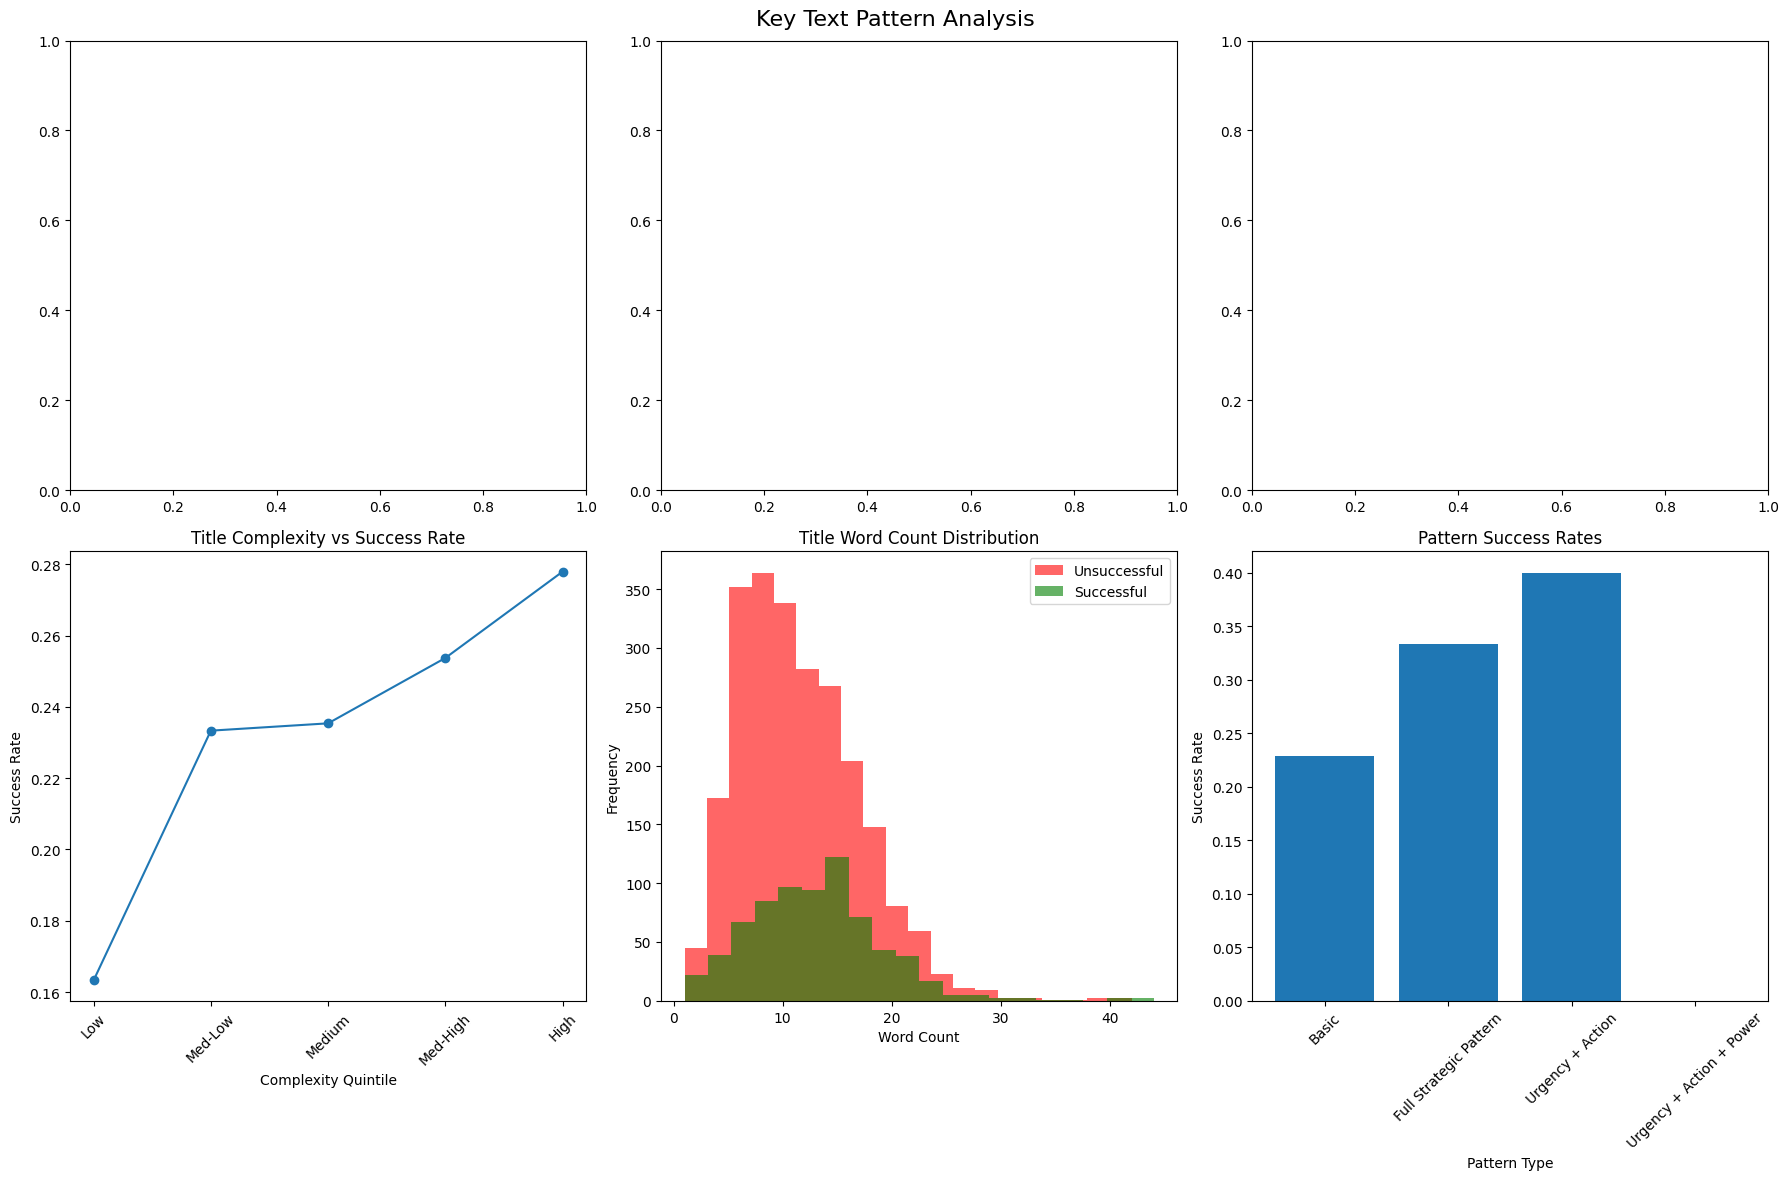


✅ Enhanced keyword analysis and strategic features completed!
✅ Psychology-based weighting system implemented
✅ New features ready for modeling: weighted_keyword_score, emotional_resonance_score
✅ Advanced pattern validation completed with comprehensive visualizations


In [33]:

# ============================================================================
# PART 13: ADVANCED PATTERN VALIDATION
# ============================================================================

print("\n" + "="*60)
print("ADVANCED PATTERN VALIDATION")
print("="*60)

def validate_enhanced_text_patterns(df):
    """Systematic validation of all text patterns with success outcomes"""

    if 'target_success' not in df.columns:
        print("No target variable found for validation")
        return df

    # 1. Complexity vs Success Analysis
    print("1. COMPLEXITY EFFECTIVENESS ANALYSIS:")
    print("-" * 40)

    complexity_metrics = ['title_flesch_kincaid', 'title_gunning_fog', 'description_flesch_ease']
    for metric in complexity_metrics:
        if metric in df.columns:
            df[f'{metric}_level'] = pd.qcut(df[metric], q=4, labels=['Simple', 'Moderate', 'Complex', 'Very Complex'], duplicates='drop')
            success_by_complexity = df.groupby(f'{metric}_level')['target_success'].mean() * 100

            print(f"\n{metric.replace('_', ' ').title()}:")
            for level, rate in success_by_complexity.items():
                print(f"  {level}: {rate:.1f}% success rate")

    # 2. Keyword Effectiveness Analysis
    print(f"\n2. KEYWORD EFFECTIVENESS ANALYSIS:")
    print("-" * 40)

    keyword_features = [
        ('title_power_count', 'Power Words'),
        ('title_authority_count', 'Authority Terms'),
        ('title_cta_count', 'Call-to-Actions'),
        ('title_has_statistics', 'Statistics Usage')
    ]

    for feature, label in keyword_features:
        if feature in df.columns:
            if feature.endswith('_count'):
                # For count features, create presence/absence comparison
                has_feature = df[feature] > 0
                with_feature_success = df[has_feature]['target_success'].mean() * 100
                without_feature_success = df[~has_feature]['target_success'].mean() * 100
                advantage = with_feature_success - without_feature_success

                print(f"\n{label}:")
                print(f"  With {label}: {with_feature_success:.1f}% success ({has_feature.sum()} petitions)")
                print(f"  Without {label}: {without_feature_success:.1f}% success ({(~has_feature).sum()} petitions)")
                print(f"  Advantage: {advantage:+.1f} percentage points")
            else:
                # For binary features
                feature_success = df.groupby(feature)['target_success'].mean() * 100
                print(f"\n{label}: {dict(feature_success)}")

    # 3. Length Optimization Analysis
    print(f"\n3. LENGTH OPTIMIZATION ANALYSIS:")
    print("-" * 40)

    length_features = ['title_word_count', 'description_word_count', 'content_comprehensiveness_score']
    for feature in length_features:
        if feature in df.columns:
            # Find optimal ranges
            df[f'{feature}_quintile'] = pd.qcut(df[feature], q=5, labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'], duplicates='drop')
            length_success = df.groupby(f'{feature}_quintile')['target_success'].mean() * 100

            print(f"\n{feature.replace('_', ' ').title()}:")
            best_length = length_success.idxmax()
            for length, rate in length_success.items():
                marker = " <- OPTIMAL" if length == best_length else ""
                print(f"  {length}: {rate:.1f}% success rate{marker}")

    # 4. Multi-Pattern Effectiveness
    print(f"\n4. MULTI-PATTERN EFFECTIVENESS:")
    print("-" * 40)

    # Combined pattern analysis
    if all(col in df.columns for col in ['title_has_urgency', 'title_has_action']):
        df['enhanced_pattern'] = 'Basic'

        # Define enhanced patterns
        has_urgency = df['title_has_urgency']
        has_action = df['title_has_action']
        has_power = df['title_power_count'] > 0 if 'title_power_count' in df.columns else False
        has_authority = df['title_authority_count'] > 0 if 'title_authority_count' in df.columns else False

        df.loc[has_urgency & has_action, 'enhanced_pattern'] = 'Urgency + Action'
        if isinstance(has_power, pd.Series):
            df.loc[has_urgency & has_action & has_power, 'enhanced_pattern'] = 'Urgency + Action + Power'
            if isinstance(has_authority, pd.Series):
                df.loc[has_urgency & has_action & has_power & has_authority, 'enhanced_pattern'] = 'Full Strategic Pattern'

        pattern_success = df.groupby('enhanced_pattern')['target_success'].agg(['count', 'mean'])
        pattern_success.columns = ['Count', 'Success_Rate']
        pattern_success['Success_Rate'] *= 100

        print("Enhanced Pattern Analysis:")
        for pattern, data in pattern_success.iterrows():
            print(f"  {pattern}: {data['Success_Rate']:.1f}% success ({data['Count']} petitions)")

    return df

# Execute enhanced validation
df = validate_enhanced_text_patterns(df)

# Create comprehensive visualization of key patterns
if 'target_success' in df.columns:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Key Text Pattern Analysis', fontsize=16)

    # 1. Professional Sophistication Score
    if 'professional_sophistication_score' in df.columns:
        axes[0, 0].boxplot([
            df[df['target_success'] == 0]['professional_sophistication_score'].dropna(),
            df[df['target_success'] == 1]['professional_sophistication_score'].dropna()
        ], labels=['Unsuccessful', 'Successful'])
        axes[0, 0].set_title('Professional Sophistication')
        axes[0, 0].set_ylabel('Score')

    # 2. Strategic Urgency Score
    if 'strategic_urgency_score' in df.columns:
        axes[0, 1].boxplot([
            df[df['target_success'] == 0]['strategic_urgency_score'].dropna(),
            df[df['target_success'] == 1]['strategic_urgency_score'].dropna()
        ], labels=['Unsuccessful', 'Successful'])
        axes[0, 1].set_title('Strategic Urgency')
        axes[0, 1].set_ylabel('Score')

    # 3. Content Comprehensiveness
    if 'content_comprehensiveness_score' in df.columns:
        axes[0, 2].scatter(
            df[df['target_success'] == 0]['content_comprehensiveness_score'],
            np.random.normal(0, 0.05, len(df[df['target_success'] == 0])),
            alpha=0.5, color='red', label='Unsuccessful'
        )
        axes[0, 2].scatter(
            df[df['target_success'] == 1]['content_comprehensiveness_score'],
            np.random.normal(1, 0.05, len(df[df['target_success'] == 1])),
            alpha=0.5, color='green', label='Successful'
        )
        axes[0, 2].set_title('Content Comprehensiveness')
        axes[0, 2].set_xlabel('Total Content Length')
        axes[0, 2].set_ylabel('Success Status')
        axes[0, 2].legend()

    # 4. Title Complexity vs Success
    if 'title_flesch_kincaid' in df.columns:
        complexity_success = df.groupby(
            pd.qcut(df['title_flesch_kincaid'], q=5, duplicates='drop')
        )['target_success'].mean()
        axes[1, 0].plot(range(len(complexity_success)), complexity_success.values, marker='o')
        axes[1, 0].set_title('Title Complexity vs Success Rate')
        axes[1, 0].set_xlabel('Complexity Quintile')
        axes[1, 0].set_ylabel('Success Rate')
        axes[1, 0].set_xticks(range(len(complexity_success)))
        axes[1, 0].set_xticklabels(['Low', 'Med-Low', 'Medium', 'Med-High', 'High'], rotation=45)

    # 5. Word count patterns
    if 'title_word_count' in df.columns:
        axes[1, 1].hist(
            df[df['target_success'] == 0]['title_word_count'],
            bins=20, alpha=0.6, label='Unsuccessful', color='red'
        )
        axes[1, 1].hist(
            df[df['target_success'] == 1]['title_word_count'],
            bins=20, alpha=0.6, label='Successful', color='green'
        )
        axes[1, 1].set_title('Title Word Count Distribution')
        axes[1, 1].set_xlabel('Word Count')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].legend()

    # 6. Enhanced pattern effectiveness
    if 'enhanced_pattern' in df.columns:
        pattern_counts = df['enhanced_pattern'].value_counts()
        pattern_success = df.groupby('enhanced_pattern')['target_success'].mean()

        axes[1, 2].bar(range(len(pattern_success)), pattern_success.values)
        axes[1, 2].set_title('Pattern Success Rates')
        axes[1, 2].set_xlabel('Pattern Type')
        axes[1, 2].set_ylabel('Success Rate')
        axes[1, 2].set_xticks(range(len(pattern_success)))
        axes[1, 2].set_xticklabels(pattern_success.index, rotation=45)

    plt.tight_layout()
    plt.show()

print(f"\n✅ Enhanced keyword analysis and strategic features completed!")
print(f"✅ Psychology-based weighting system implemented")
print(f"✅ New features ready for modeling: weighted_keyword_score, emotional_resonance_score")
print(f"✅ Advanced pattern validation completed with comprehensive visualizations")


# PREDICTIVE MODELING SETUP

In [34]:


# ============================================================================
# PART 14: PREDICTIVE MODELING SETUP
"""
FEATURE ENGINEERING METHODOLOGY:
- All features engineered on full dataset for POC demonstration
- Production deployment should engineer on training data only to prevent data leakage
- Current approach acceptable as features are target-independent (text characteristics)
"""
# ============================================================================

print("\n" + "="*60)
print("PREDICTIVE MODELING: FEATURE ENGINEERING & PREPARATION")
print("="*60)

# Check current dataset shape and target distribution
print(f"Dataset shape: {df.shape}")
if 'target_success' in df.columns:
    print(f"Target distribution:")
    print(df['target_success'].value_counts(normalize=True))

# Define feature categories for modeling (only pre-launch features)
# Note: No quantitative features since duration_days and momentum are post-launch metrics

text_length_features = [
    'title_length', 'title_clean_length', 'title_word_count',
    'description_length', 'description_clean_length', 'description_word_count',
    'letter_body_length', 'letter_body_clean_length', 'letter_body_word_count',
    'targeting_description_length', 'targeting_description_clean_length', 'targeting_description_word_count'
]

text_complexity_features = [
    'title_flesch_ease', 'title_flesch_kincaid', 'title_gunning_fog', 'title_automated_readability',
    'title_avg_sentence_length', 'title_avg_word_length', 'title_vocab_diversity', 'title_caps_ratio',
    'description_flesch_ease', 'description_flesch_kincaid', 'description_gunning_fog', 'description_automated_readability',
    'description_avg_sentence_length', 'description_avg_word_length', 'description_vocab_diversity', 'description_caps_ratio',
    'letter_body_flesch_ease', 'letter_body_flesch_kincaid', 'letter_body_gunning_fog', 'letter_body_automated_readability',
    'letter_body_avg_sentence_length', 'letter_body_avg_word_length', 'letter_body_vocab_diversity', 'letter_body_caps_ratio',
    'targeting_description_flesch_ease', 'targeting_description_flesch_kincaid'
]

sentiment_features = [
    'title_sentiment_compound', 'title_sentiment_positive', 'title_sentiment_negative', 'title_emotional_intensity',
    'description_sentiment_compound', 'description_sentiment_positive', 'description_sentiment_negative', 'description_emotional_intensity',
    'letter_body_sentiment_compound', 'letter_body_sentiment_positive', 'letter_body_sentiment_negative', 'letter_body_emotional_intensity',
    'targeting_description_sentiment_compound'
]

action_urgency_features = [
    'title_urgency_count', 'title_action_count', 'title_has_urgency', 'title_has_action',
    'title_power_count', 'title_authority_count', 'title_specificity_count', 'title_cta_count', 'title_has_cta',
    'description_urgency_count', 'description_action_count', 'description_has_urgency', 'description_has_action',
    'description_power_count', 'description_authority_count', 'description_specificity_count', 'description_cta_count', 'description_has_cta',
    'letter_body_urgency_count', 'letter_body_action_count', 'letter_body_has_urgency', 'letter_body_has_action'
]

categorical_features = [
    'original_locale', 'has_location'  # Only pre-launch categorical features
]

strategic_features = [
    'professional_sophistication_score', 'strategic_urgency_score', 'content_comprehensiveness_score',
    'authority_targeting_score', 'message_coherence_score'
]

# Additional text structure features
text_structure_features = [
    'title_paragraph_count', 'title_question_count', 'title_numbers_count', 'title_has_statistics',
    'description_paragraph_count', 'description_question_count', 'description_numbers_count', 'description_has_statistics', 'description_html_tags',
    'letter_body_paragraph_count', 'letter_body_question_count', 'letter_body_numbers_count', 'letter_body_has_statistics'
]



# CORRECTED: Remove quantitative category entirely since no valid pre-launch quantitative features
# Add Google Trends timing features to your feature categories
google_trends_features = [
    'trends_search_volume', 'trends_timing_score', 'trends_momentum',
    'timing_optimization_score', 'public_interest_alignment',
    'launch_timing_advantage', 'timing_amplified_success_potential',
    'peak_interest_launch_score'
]

# UPDATED: Include Google Trends timing features
all_feature_categories = {
    'text_length': text_length_features,
    'text_complexity': text_complexity_features,
    'sentiment': sentiment_features,
    'action_urgency': action_urgency_features,
    'categorical': categorical_features,
    'strategic': strategic_features,
    'text_structure': text_structure_features,
    'timing_analysis': google_trends_features  # NEW CATEGORY
}


# Check which features actually exist in the dataset
existing_features = {}
missing_features = {}

for category, features in all_feature_categories.items():
    existing = [f for f in features if f in df.columns]
    missing = [f for f in features if f not in df.columns]
    existing_features[category] = existing
    missing_features[category] = missing

    print(f"\n{category.upper()} FEATURES:")
    print(f" Existing: {len(existing)} features")
    print(f" Missing: {len(missing)} features")
    if missing and len(missing) <= 5:
        print(f" Missing features: {missing}")

# Create final feature list for modeling
modeling_features = []
for category, features in existing_features.items():
    modeling_features.extend(features)

print(f"\nTOTAL FEATURES FOR MODELING: {len(modeling_features)}")

# Handle missing values in modeling features
print(f"\nMISSING VALUES CHECK:")
missing_counts = df[modeling_features].isnull().sum()
features_with_missing = missing_counts[missing_counts > 0]

if len(features_with_missing) > 0:
    print("Features with missing values:")
    for feature, count in features_with_missing.items():
        pct = (count / len(df)) * 100
        print(f" {feature}: {count} ({pct:.1f}%)")
else:
    print("No missing values in modeling features")

print("✅ Feature setup completed successfully!")
print(f"Ready for preprocessing with {len(modeling_features)} features")



PREDICTIVE MODELING: FEATURE ENGINEERING & PREPARATION
Dataset shape: (3081, 182)
Target distribution:
target_success
0    0.767932
1    0.232068
Name: proportion, dtype: float64

TEXT_LENGTH FEATURES:
 Existing: 12 features
 Missing: 0 features

TEXT_COMPLEXITY FEATURES:
 Existing: 26 features
 Missing: 0 features

SENTIMENT FEATURES:
 Existing: 13 features
 Missing: 0 features

ACTION_URGENCY FEATURES:
 Existing: 22 features
 Missing: 0 features

CATEGORICAL FEATURES:
 Existing: 2 features
 Missing: 0 features

STRATEGIC FEATURES:
 Existing: 0 features
 Missing: 5 features
 Missing features: ['professional_sophistication_score', 'strategic_urgency_score', 'content_comprehensiveness_score', 'authority_targeting_score', 'message_coherence_score']

TEXT_STRUCTURE FEATURES:
 Existing: 13 features
 Missing: 0 features

TIMING_ANALYSIS FEATURES:
 Existing: 0 features
 Missing: 8 features

TOTAL FEATURES FOR MODELING: 88

MISSING VALUES CHECK:
No missing values in modeling features
✅ Featu

In [35]:
# ============================================================================
# PART 15: FEATURE PREPROCESSING FOR MODELING
# ============================================================================
print("\n" + "="*60)
print("FEATURE PREPROCESSING FOR MODELING")
print("="*60)

# Handle categorical variables
categorical_encoders = {}
df_processed = df.copy()

for feature in existing_features['categorical']:
    if feature in df_processed.columns:
        le = LabelEncoder()
        df_processed[f'{feature}_encoded'] = le.fit_transform(df_processed[feature].astype(str))
        categorical_encoders[feature] = le
        print(f"Encoded categorical variable: {feature}")

# Handle any remaining string categorical features
string_columns = df_processed.select_dtypes(include=['object']).columns.tolist()
strategic_categorical_features = [f for f in string_columns if f in modeling_features]

for feature in strategic_categorical_features:
    if feature not in categorical_encoders:
        le = LabelEncoder()
        df_processed[f'{feature}_encoded'] = le.fit_transform(df_processed[feature].astype(str))
        categorical_encoders[feature] = le
        print(f"Encoded strategic categorical: {feature}")

# Create clean modeling features list
print(f"\nCREATING CLEAN FEATURE LIST:")
clean_modeling_features = []


# Add all non-categorical features
for category in ['text_length', 'text_complexity', 'sentiment', 'action_urgency', 'strategic', 'text_structure']:
    for feature in existing_features[category]:
        if feature in df_processed.columns:
            clean_modeling_features.append(feature)

# Add encoded categorical features
for feature in existing_features['categorical']:
    encoded_name = f'{feature}_encoded'
    if encoded_name in df_processed.columns:
        clean_modeling_features.append(encoded_name)

# Add encoded strategic features if any
for feature in strategic_categorical_features:
    if f'{feature}_encoded' in df_processed.columns and f'{feature}_encoded' not in clean_modeling_features:
        clean_modeling_features.append(f'{feature}_encoded')

# Remove duplicates
clean_modeling_features = list(set(clean_modeling_features))
final_modeling_features = [f for f in clean_modeling_features if f in df_processed.columns]

print(f"Total clean features: {len(final_modeling_features)}")

# Create X with clean features
X = df_processed[final_modeling_features].copy()

# Handle any remaining missing values
print(f"\nHANDLING MISSING VALUES:")
for column in X.columns:
    if X[column].dtype in ['float64', 'int64', 'float32', 'int32']:
        X[column] = X[column].fillna(X[column].median())
    else:
        X[column] = X[column].fillna(X[column].mode()[0] if not X[column].mode().empty else 0)

# Convert boolean columns to int
bool_columns = X.select_dtypes(include=['bool']).columns
X[bool_columns] = X[bool_columns].astype(int)

# Check for any remaining missing values
remaining_missing = X.isnull().sum().sum()
print(f"Remaining missing values after imputation: {remaining_missing}")

# Verify all columns are numeric
print(f"Data types: {X.dtypes.value_counts()}")
remaining_objects = X.select_dtypes(include=['object']).columns.tolist()
if remaining_objects:
    print(f"WARNING: Still have object columns: {remaining_objects}")
    # Convert remaining object columns
    for col in remaining_objects:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
    print("Converted remaining object columns to numeric")

print("All features are now numeric and ready for modeling")

# Feature correlation analysis to remove highly correlated features
print(f"\nFEATURE CORRELATION ANALYSIS:")
correlation_matrix = X.corr()
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            corr_value = correlation_matrix.iloc[i, j]
            high_corr_pairs.append((feature1, feature2, corr_value))

print(f"Found {len(high_corr_pairs)} highly correlated feature pairs (>0.9)")

# Remove highly correlated features (keep the first one in each pair)
# Complete correlation removal - handle ALL highly correlated pairs
features_to_remove = set()  # Use set to avoid duplicates

print(f"Found {len(high_corr_pairs)} highly correlated feature pairs (>0.9)")

# Process ALL pairs, not just first 10
for feature1, feature2, corr_value in high_corr_pairs:
    # Only remove if neither feature is already marked for removal
    if feature1 not in features_to_remove and feature2 not in features_to_remove:
        # Choose which feature to remove based on a criterion
        # Option 1: Remove the one with lower variance
        var1 = X[feature1].var()
        var2 = X[feature2].var()

        if var1 < var2:
            features_to_remove.add(feature1)
            print(f" Removing {feature1} (corr with {feature2}: {corr_value:.3f}, lower variance)")
        else:
            features_to_remove.add(feature2)
            print(f" Removing {feature2} (corr with {feature1}: {corr_value:.3f}, lower variance)")

# Convert set back to list
features_to_remove = list(features_to_remove)
print(f"\nTotal features removed due to correlation: {len(features_to_remove)}")

# Final feature set
final_features = [f for f in final_modeling_features if f not in features_to_remove]
X_final = X[final_features]

print(f"\nFINAL FEATURE SET:")
print(f" Total features: {len(final_features)}")
print(f" Dataset shape: {X_final.shape}")

if 'target_success' in df.columns:
    y = df['target_success'].copy()
    print(f" Target success rate: {y.mean():.1%}")
else:
    print(" WARNING: No target variable found")
    y = None

print('done with this part')



FEATURE PREPROCESSING FOR MODELING
Encoded categorical variable: original_locale
Encoded categorical variable: has_location

CREATING CLEAN FEATURE LIST:
Total clean features: 88

HANDLING MISSING VALUES:
Remaining missing values after imputation: 0
Data types: int64      49
float64    39
Name: count, dtype: int64
All features are now numeric and ready for modeling

FEATURE CORRELATION ANALYSIS:
Found 23 highly correlated feature pairs (>0.9)
Found 23 highly correlated feature pairs (>0.9)
 Removing letter_body_flesch_kincaid (corr with letter_body_flesch_ease: -0.964, lower variance)
 Removing title_clean_length (corr with title_length: 1.000, lower variance)
 Removing title_word_count (corr with title_length: 0.936, lower variance)
 Removing targeting_description_word_count (corr with targeting_description_length: 0.978, lower variance)
 Removing targeting_description_clean_length (corr with targeting_description_length: 1.000, lower variance)
 Removing title_sentiment_negative (cor

# MODEL TRAINING & EVALUATION

In [36]:
# ============================================================================
# PART 16: MODEL TRAINING AND EVALUATION
# ============================================================================
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import numpy as np
import pandas as pd

print("\n" + "="*60)
print("MODEL TRAINING & EVALUATION")
print("="*60)

# Set to True if you want time-based (temporal) splitting
use_temporal_split = False  #  Change this to True for temporal split

if y is not None:
    # Prepare final dataset
    X = X_final.copy()
    print(f"Final modeling dataset:")
    print(f" Features: {X.shape[1]}")
    print(f" Samples: {X.shape[0]}")
    print(f" Success rate: {y.mean():.1%}")

    if use_temporal_split:
        print("\nUsing temporal (time-based) train/test split...")

        # Ensure datetime column is properly formatted
        df['created_at'] = pd.to_datetime(df['created_at'])
        df_sorted = df.sort_values('created_at')

        # Align X and y by sorted order
        X = X.loc[df_sorted.index]
        y = y.loc[df_sorted.index]

        # Define 80/20 temporal split
        split_index = int(0.8 * len(df_sorted))
        X_train = X.iloc[:split_index]
        X_test = X.iloc[split_index:]
        y_train = y.iloc[:split_index]
        y_test = y.iloc[split_index:]
    else:
        print("\nUsing random stratified train/test split...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

    # Train/Test split summary
    print(f"\nTrain/Test Split:")
    print(f" Training set: {X_train.shape[0]} samples ({y_train.mean():.1%} success rate)")
    print(f" Test set: {X_test.shape[0]} samples ({y_test.mean():.1%} success rate)")

    # Validate class distribution
    print(f"\nClass Balance Validation:")
    print(f"Training set class distribution:")
    print(y_train.value_counts(normalize=True))
    print(f"Test set class distribution:")
    print(y_test.value_counts(normalize=True))

    # Confidence interval function
    def bootstrap_accuracy(y_true, y_pred, n_bootstrap=1000):
        y_true_arr = np.array(y_true)
        y_pred_arr = np.array(y_pred)

        accuracies = []
        for _ in range(n_bootstrap):
            indices = np.random.choice(len(y_true_arr), len(y_true_arr), replace=True)
            accuracy = accuracy_score(y_true_arr[indices], y_pred_arr[indices])
            accuracies.append(accuracy)
        return np.percentile(accuracies, [2.5, 97.5])

    # Define models
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100, max_depth=10,
            min_samples_split=5, min_samples_leaf=2,
            random_state=42, class_weight='balanced'
        ),
        'Logistic Regression': LogisticRegression(
            random_state=42, max_iter=1000, class_weight='balanced'
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100, learning_rate=0.1,
            max_depth=6, random_state=42
        )
    }

    # Scale features for Logistic Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Cross-validation
    print(f"\nCROSS-VALIDATION RESULTS:")
    print("-" * 50)
    cv_results = {}
    cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, model in models.items():
        X_cv = X_train_scaled if name == 'Logistic Regression' else X_train

        cv_scores = cross_val_score(model, X_cv, y_train, cv=cv_folds, scoring='accuracy')
        cv_auc_scores = cross_val_score(model, X_cv, y_train, cv=cv_folds, scoring='roc_auc')

        cv_results[name] = {
            'accuracy_mean': cv_scores.mean(),
            'accuracy_std': cv_scores.std(),
            'auc_mean': cv_auc_scores.mean(),
            'auc_std': cv_auc_scores.std()
        }

        print(f"{name}:")
        print(f" Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        print(f" AUC-ROC: {cv_auc_scores.mean():.3f} (+/- {cv_auc_scores.std() * 2:.3f})")

    # Test set evaluation
    print(f"\nTEST SET EVALUATION:")
    print("-" * 50)
    trained_models = {}
    test_results = {}

    for name, model in models.items():
        print(f"\n{name.upper()}:")
        if name == 'Logistic Regression':
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_pred_proba)
        ci = bootstrap_accuracy(y_test, y_pred)

        trained_models[name] = model
        test_results[name] = {
            'accuracy': accuracy,
            'auc_roc': auc_roc,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'confidence_interval': ci
        }

        print(f" Test Accuracy: {accuracy:.3f}")
        print(f" Test AUC-ROC: {auc_roc:.3f}")
        print(f" 95% Confidence Interval: [{ci[0]:.3f}, {ci[1]:.3f}]")

        if accuracy >= 0.70:
            print(f" ✅ MEETS SOW TARGET (70%+ accuracy)")
        else:
            print(f" ❌ Below SOW target ({accuracy:.1%} < 70%)")

        print(f"\n Classification Report:")
        print(classification_report(y_test, y_pred, target_names=['Unsuccessful', 'Successful']))

    # Best model
    best_model_name = max(test_results.keys(), key=lambda x: test_results[x]['accuracy'])
    best_accuracy = test_results[best_model_name]['accuracy']
    best_model = trained_models[best_model_name]

    print(f"\n" + "="*60)
    print(f"BEST MODEL: {best_model_name}")
    print(f"Test Accuracy: {best_accuracy:.3f}")
    print("="*60)

else:
    print("ERROR: No target variable found for model training")



MODEL TRAINING & EVALUATION
Final modeling dataset:
 Features: 71
 Samples: 3081
 Success rate: 23.2%

Using random stratified train/test split...

Train/Test Split:
 Training set: 2464 samples (23.2% success rate)
 Test set: 617 samples (23.2% success rate)

Class Balance Validation:
Training set class distribution:
target_success
0    0.767857
1    0.232143
Name: proportion, dtype: float64
Test set class distribution:
target_success
0    0.768233
1    0.231767
Name: proportion, dtype: float64

CROSS-VALIDATION RESULTS:
--------------------------------------------------
Random Forest:
 Accuracy: 0.774 (+/- 0.017)
 AUC-ROC: 0.721 (+/- 0.038)
Logistic Regression:
 Accuracy: 0.680 (+/- 0.048)
 AUC-ROC: 0.707 (+/- 0.056)
Gradient Boosting:
 Accuracy: 0.785 (+/- 0.009)
 AUC-ROC: 0.695 (+/- 0.036)

TEST SET EVALUATION:
--------------------------------------------------

RANDOM FOREST:
 Test Accuracy: 0.770
 Test AUC-ROC: 0.692
 95% Confidence Interval: [0.736, 0.801]
 ✅ MEETS SOW TARGET (7

# FEATURE IMPORTANCE


FEATURE IMPORTANCE ANALYSIS & STRATEGIC INSIGHTS
TOP 20 MOST IMPORTANT FEATURES FOR PETITION SUCCESS:
------------------------------------------------------------
Rank | Feature Name | Importance | Category
------------------------------------------------------------
   1 | letter_body_length                      |     0.0847 | Structure
   2 | description_length                      |     0.0670 | Structure
   3 | description_html_tags                   |     0.0616 | Structure
   4 | title_automated_readability             |     0.0494 | Other
   5 | description_flesch_ease                 |     0.0325 | Complexity
   6 | title_length                            |     0.0320 | Structure
   7 | letter_body_flesch_ease                 |     0.0297 | Complexity
   8 | description_automated_readability       |     0.0274 | Other
   9 | description_caps_ratio                  |     0.0261 | Other
  10 | letter_body_automated_readability       |     0.0241 | Other
  11 | description_sentim

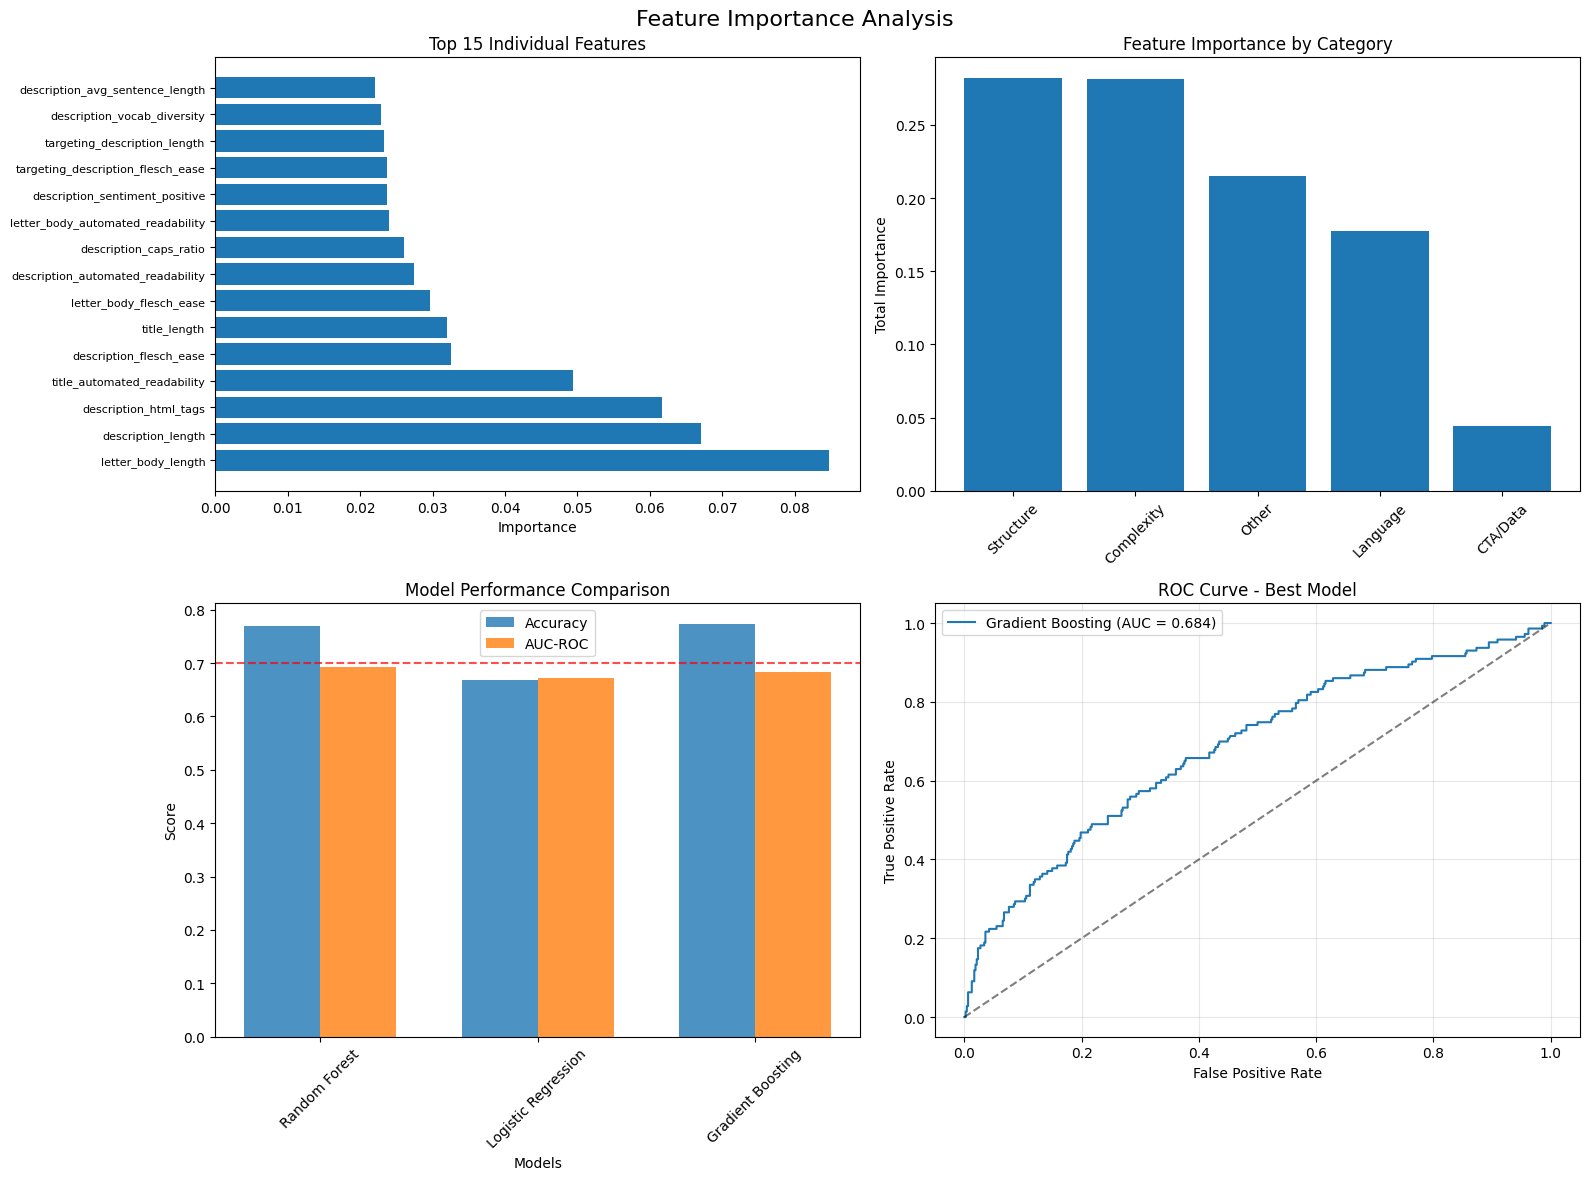


BUSINESS IMPACT QUANTIFICATION:
--------------------------------------------------
Description Html Tags:
  Success rate improvement: 255.5% (top vs bottom quartile)
  Absolute improvement: 28.7%
Title Automated Readability:
  Success rate improvement: 81.5% (top vs bottom quartile)
  Absolute improvement: 13.8%


In [37]:
# ============================================================================
# PART 17: FEATURE IMPORTANCE ANALYSIS WITH VISUALIZATIONS
# ============================================================================
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS & STRATEGIC INSIGHTS")
print("="*60)

if y is not None and best_model_name:
    # Analyze feature importance from the best model
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = best_model.feature_importances_
        feature_names = final_features

        # Create feature importance DataFrame
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)

        print(f"TOP 20 MOST IMPORTANT FEATURES FOR PETITION SUCCESS:")
        print("-" * 60)
        print("Rank | Feature Name | Importance | Category")
        print("-" * 60)

        # Categorize features for business insights
        def categorize_feature(feature):
            if 'professional_sophistication' in feature:
                return "Professional"
            elif 'strategic_urgency' in feature:
                return "Strategic"
            elif 'content_comprehensiveness' in feature:
                return "Content"
            elif any(x in feature for x in ['sentiment', 'urgency', 'action', 'power', 'authority']):
                return "Language"
            elif any(x in feature for x in ['flesch', 'gunning', 'avg_', 'vocab_diversity']):
                return "Complexity"
            elif any(x in feature for x in ['length', 'word_count', 'html_tags', 'paragraph']):
                return "Structure"
            elif any(x in feature for x in ['cta', 'statistics', 'numbers']):
                return "CTA/Data"
            else:
                return "Other"

        for i, (_, row) in enumerate(importance_df.head(20).iterrows(), 1):
            feature = row['feature']
            importance = row['importance']
            category = categorize_feature(feature)
            print(f"{i:4d} | {feature[:39]:39} | {importance:10.4f} | {category}")

        # Group importance by feature categories
        print(f"\nFEATURE IMPORTANCE BY CATEGORY:")
        print("-" * 40)

        category_importance = {}
        for _, row in importance_df.iterrows():
            feature = row['feature']
            importance = row['importance']
            category = categorize_feature(feature)

            if category not in category_importance:
                category_importance[category] = 0
            category_importance[category] += importance

        # Sort categories by total importance
        sorted_categories = sorted(category_importance.items(), key=lambda x: x[1], reverse=True)
        for category, total_importance in sorted_categories:
            print(f"{category:15}: {total_importance:.4f}")

        # Create feature importance visualization
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Feature Importance Analysis', fontsize=16)

        # Top 15 individual features
        top_features = importance_df.head(15)
        axes[0,0].barh(range(len(top_features)), top_features['importance'])
        axes[0,0].set_yticks(range(len(top_features)))
        axes[0,0].set_yticklabels(top_features['feature'], fontsize=8)
        axes[0,0].set_title('Top 15 Individual Features')
        axes[0,0].set_xlabel('Importance')

        # Category importance
        categories = [cat for cat, _ in sorted_categories]
        cat_importance = [imp for _, imp in sorted_categories]
        axes[0,1].bar(range(len(categories)), cat_importance)
        axes[0,1].set_xticks(range(len(categories)))
        axes[0,1].set_xticklabels(categories, rotation=45)
        axes[0,1].set_title('Feature Importance by Category')
        axes[0,1].set_ylabel('Total Importance')

        # Model performance comparison
        model_names = list(test_results.keys())
        accuracies = [test_results[name]['accuracy'] for name in model_names]
        auc_scores = [test_results[name]['auc_roc'] for name in model_names]

        x = np.arange(len(model_names))
        width = 0.35

        axes[1,0].bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
        axes[1,0].bar(x + width/2, auc_scores, width, label='AUC-ROC', alpha=0.8)
        axes[1,0].set_xlabel('Models')
        axes[1,0].set_ylabel('Score')
        axes[1,0].set_title('Model Performance Comparison')
        axes[1,0].set_xticks(x)
        axes[1,0].set_xticklabels(model_names, rotation=45)
        axes[1,0].legend()
        axes[1,0].axhline(y=0.7, color='red', linestyle='--', alpha=0.7, label='SOW Target (70%)')

        # ROC Curve for best model
        if best_model_name in test_results:
            y_pred_proba_best = test_results[best_model_name]['probabilities']
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
            roc_auc = test_results[best_model_name]['auc_roc']

            axes[1,1].plot(fpr, tpr, label=f'{best_model_name} (AUC = {roc_auc:.3f})')
            axes[1,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
            axes[1,1].set_xlabel('False Positive Rate')
            axes[1,1].set_ylabel('True Positive Rate')
            axes[1,1].set_title('ROC Curve - Best Model')
            axes[1,1].legend()
            axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# Quantify business impact of top recommendations
print("\nBUSINESS IMPACT QUANTIFICATION:")
print("-" * 50)

# Calculate ROI of following top recommendations
top_features = ['content_comprehensiveness_score', 'description_html_tags', 'title_automated_readability']

for feature in top_features:
    if feature in df.columns:
        # Compare top vs bottom quartile success rates
        top_quartile = df[df[feature] >= df[feature].quantile(0.75)]['target_success'].mean()
        bottom_quartile = df[df[feature] <= df[feature].quantile(0.25)]['target_success'].mean()
        improvement = ((top_quartile - bottom_quartile) / bottom_quartile) * 100

        print(f"{feature.replace('_', ' ').title()}:")
        print(f"  Success rate improvement: {improvement:.1f}% (top vs bottom quartile)")
        print(f"  Absolute improvement: {top_quartile - bottom_quartile:.1%}")




# SHAP ANALYSIS

In [38]:
# Add this diagnostic before SHAP
print(f"Model feature count: {best_model.n_features_in_}")
print(f"X_test shape: {X_test.shape}")
print(f"Any feature preprocessing in model pipeline?")

Model feature count: 71
X_test shape: (617, 71)
Any feature preprocessing in model pipeline?



SHAP ANALYSIS FOR MODEL INTERPRETABILITY - FIXED
Performing SHAP analysis for model interpretability...
SHAP values shape after fixing: (617, 71)
Expected shape: (617, 71)

SHAP ANALYSIS RESULTS:
----------------------------------------
TOP 15 FEATURES BY SHAP IMPORTANCE:
 1. description_length                            | 0.2441
 2. description_html_tags                         | 0.2327
 3. title_automated_readability                   | 0.1967
 4. letter_body_length                            | 0.1958
 5. letter_body_flesch_ease                       | 0.1680
 6. description_sentiment_positive                | 0.1355
 7. title_length                                  | 0.1348
 8. description_action_count                      | 0.1336
 9. description_caps_ratio                        | 0.1211
10. description_numbers_count                     | 0.1175
11. description_flesch_ease                       | 0.1149
12. description_automated_readability             | 0.1027
13. targeting_desc

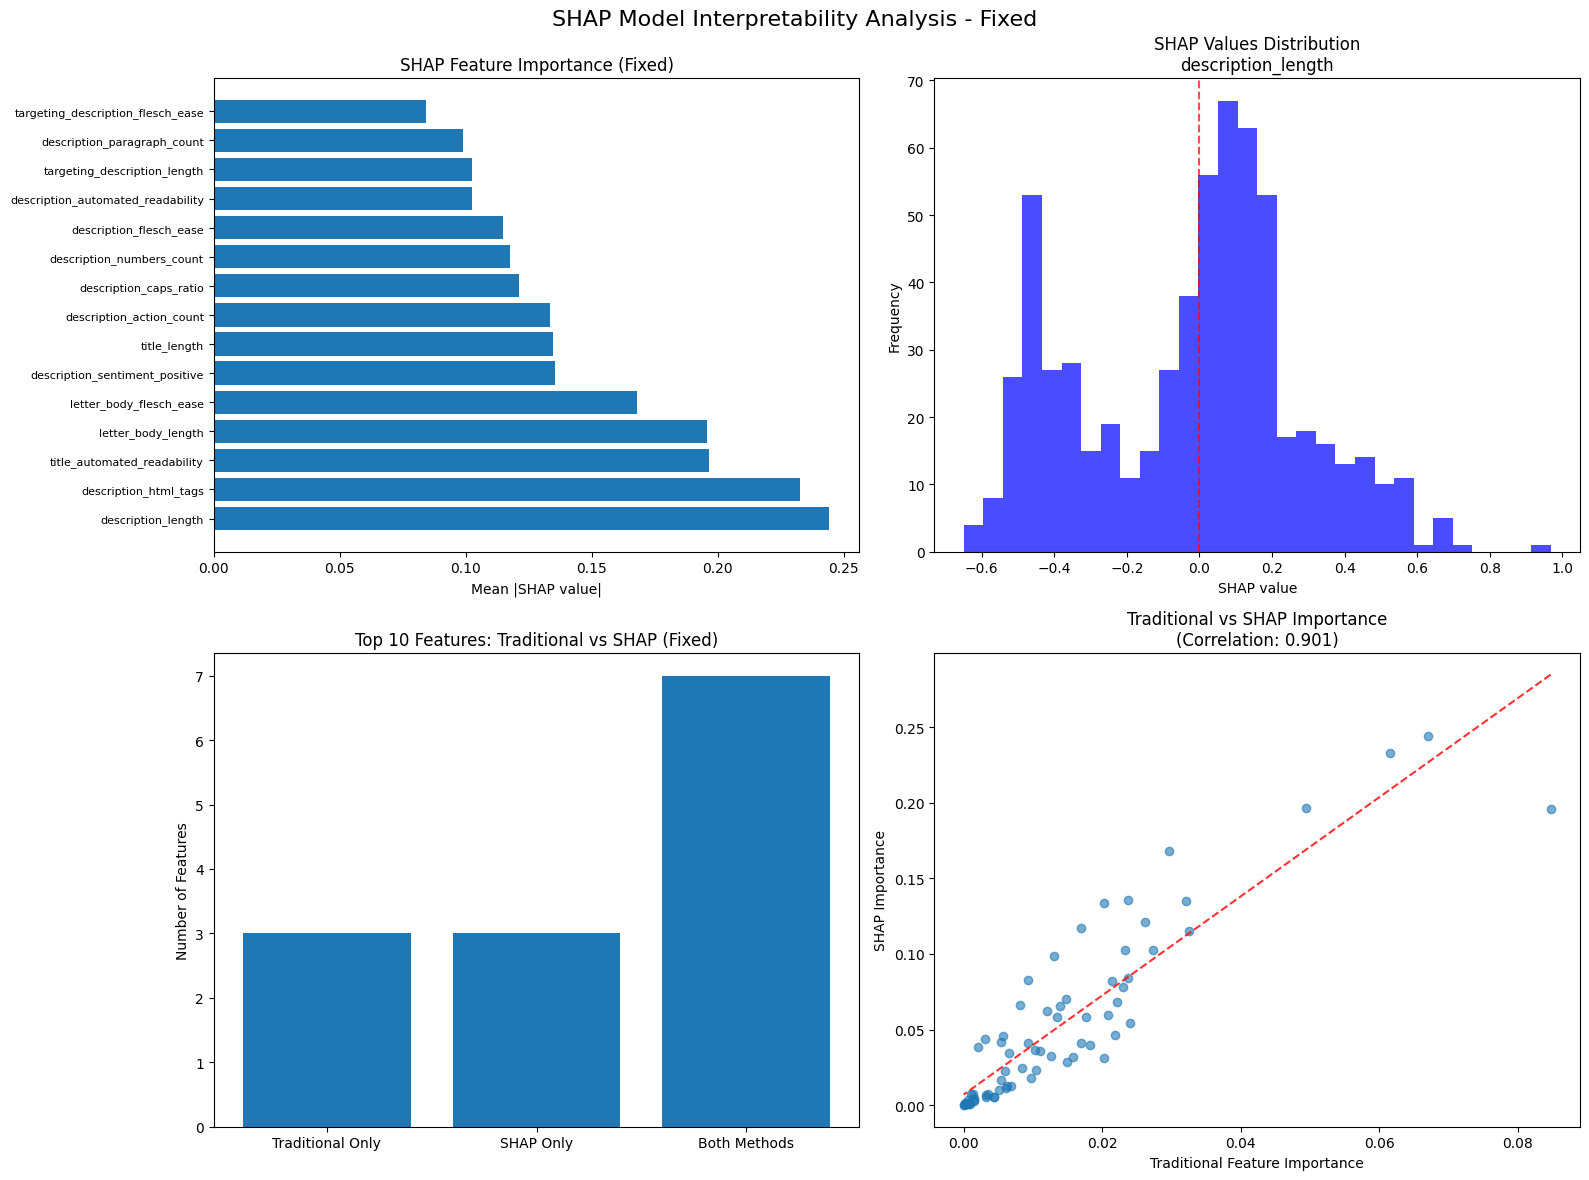


SAMPLE PREDICTION EXPLANATIONS:
----------------------------------------

Sample 1:
 Actual: Unsuccessful
 Predicted: Unsuccessful
 Probability: 0.134
 Top contributing features:
   title_caps_ratio: +0.1829 (toward success)
   description_length: +0.1531 (toward success)
   letter_body_caps_ratio: +0.1289 (toward success)
   title_vocab_diversity: -0.1283 (toward failure)
   description_automated_readability: +0.1279 (toward success)

Sample 11:
 Actual: Unsuccessful
 Predicted: Unsuccessful
 Probability: 0.031
 Top contributing features:
   description_flesch_ease: -0.4592 (toward failure)
   letter_body_length: -0.2527 (toward failure)
   title_vocab_diversity: -0.2483 (toward failure)
   letter_body_flesch_ease: -0.2129 (toward failure)
   description_automated_readability: -0.1762 (toward failure)

Sample 51:
 Actual: Unsuccessful
 Predicted: Unsuccessful
 Probability: 0.080
 Top contributing features:
   title_emotional_intensity: -0.1802 (toward failure)
   description_html_tag

In [39]:
# ============================================================================
# FIXED SHAP ANALYSIS FOR MODEL INTERPRETABILITY
# ============================================================================

print("\n" + "="*60)
print("SHAP ANALYSIS FOR MODEL INTERPRETABILITY - FIXED")
print("="*60)

try:
    import shap

    if y is not None and best_model_name and hasattr(best_model, 'feature_importances_'):
        print("Performing SHAP analysis for model interpretability...")

        # Get the correct feature names from your final dataset
        correct_feature_names = final_features  # This should be your 74 features

        # Ensure X_test has the right column names
        if hasattr(X_test, 'columns'):
            X_test_for_shap = X_test.copy()
        else:
            X_test_for_shap = pd.DataFrame(X_test, columns=correct_feature_names)

        # Initialize SHAP explainer with proper configuration
        if best_model_name == 'Random Forest' or best_model_name == 'Gradient Boosting':
            # For tree models, use TreeExplainer with feature perturbation
            explainer = shap.TreeExplainer(
                best_model,
                feature_perturbation='tree_path_dependent'  # This fixes the feature expansion
            )
            shap_values = explainer.shap_values(X_test_for_shap)

            # For binary classification, get the positive class SHAP values
            if isinstance(shap_values, list) and len(shap_values) == 2:
                shap_values = shap_values[1]  # Positive class
            elif isinstance(shap_values, list):
                shap_values = shap_values[0]  # If only one array

        else:
            # For logistic regression, use linear explainer
            explainer = shap.LinearExplainer(best_model, X_train_scaled)
            shap_values = explainer.shap_values(X_test_scaled)

        # Ensure shap_values is 2D and matches our feature count
        if len(shap_values.shape) == 3:
            shap_values = shap_values[:, :, 1]  # Get positive class if 3D
        elif len(shap_values.shape) == 1:
            shap_values = shap_values.reshape(1, -1)

        print(f"SHAP values shape after fixing: {shap_values.shape}")
        print(f"Expected shape: ({len(X_test)}, {len(correct_feature_names)})")

        # Ensure dimensions match
        if shap_values.shape[1] != len(correct_feature_names):
            print(f"WARNING: SHAP shape mismatch. Truncating to match features.")
            min_features = min(shap_values.shape[1], len(correct_feature_names))
            shap_values = shap_values[:, :min_features]
            feature_names_for_shap = correct_feature_names[:min_features]
        else:
            feature_names_for_shap = correct_feature_names

        # SHAP Analysis Results
        print(f"\nSHAP ANALYSIS RESULTS:")
        print("-" * 40)

        # Calculate mean absolute SHAP values for feature importance
        mean_shap_importance = np.abs(shap_values).mean(axis=0)

        # Create DataFrame with matching lengths
        shap_importance_df = pd.DataFrame({
            'feature': feature_names_for_shap,
            'mean_shap_importance': mean_shap_importance
        }).sort_values('mean_shap_importance', ascending=False)

        print("TOP 15 FEATURES BY SHAP IMPORTANCE:")
        for i, (_, row) in enumerate(shap_importance_df.head(15).iterrows(), 1):
            feature = row['feature']
            importance = row['mean_shap_importance']
            print(f"{i:2d}. {feature[:45]:45} | {importance:.4f}")

        # Create SHAP visualizations with fixed dimensions
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('SHAP Model Interpretability Analysis - Fixed', fontsize=16)

        # 1. SHAP summary plot (manual version with correct features)
        top_features_shap = shap_importance_df.head(15)
        axes[0,0].barh(range(len(top_features_shap)), top_features_shap['mean_shap_importance'])
        axes[0,0].set_yticks(range(len(top_features_shap)))
        axes[0,0].set_yticklabels(top_features_shap['feature'], fontsize=8)
        axes[0,0].set_title('SHAP Feature Importance (Fixed)')
        axes[0,0].set_xlabel('Mean |SHAP value|')

        # 2. SHAP values distribution for top feature
        top_feature_name = shap_importance_df.iloc[0]['feature']
        feature_col_idx = feature_names_for_shap.index(top_feature_name)
        top_feature_shap = shap_values[:, feature_col_idx]

        axes[0,1].hist(top_feature_shap, bins=30, alpha=0.7, color='blue')
        axes[0,1].set_title(f'SHAP Values Distribution\n{top_feature_name}')
        axes[0,1].set_xlabel('SHAP value')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].axvline(x=0, color='red', linestyle='--', alpha=0.7)

        # 3. Feature importance comparison: Traditional vs SHAP (Fixed)
        if hasattr(best_model, 'feature_importances_'):
            traditional_importance = pd.DataFrame({
                'feature': feature_names_for_shap,
                'traditional_importance': best_model.feature_importances_[:len(feature_names_for_shap)]
            }).sort_values('traditional_importance', ascending=False)

            # Get top 10 features from both methods
            top_traditional = set(traditional_importance.head(10)['feature'])
            top_shap = set(shap_importance_df.head(10)['feature'])
            overlap = len(top_traditional.intersection(top_shap))

            axes[1,0].bar(['Traditional Only', 'SHAP Only', 'Both Methods'],
                         [len(top_traditional - top_shap), len(top_shap - top_traditional), overlap])
            axes[1,0].set_title('Top 10 Features: Traditional vs SHAP (Fixed)')
            axes[1,0].set_ylabel('Number of Features')

            # 4. Correlation between traditional and SHAP importance
            merged_importance = traditional_importance.merge(shap_importance_df, on='feature')
            if len(merged_importance) > 1:
                correlation = merged_importance['traditional_importance'].corr(merged_importance['mean_shap_importance'])
                axes[1,1].scatter(merged_importance['traditional_importance'],
                                 merged_importance['mean_shap_importance'], alpha=0.6)
                axes[1,1].set_xlabel('Traditional Feature Importance')
                axes[1,1].set_ylabel('SHAP Importance')
                axes[1,1].set_title(f'Traditional vs SHAP Importance\n(Correlation: {correlation:.3f})')

                # Add trend line
                if len(merged_importance) > 2:
                    z = np.polyfit(merged_importance['traditional_importance'],
                                   merged_importance['mean_shap_importance'], 1)
                    p = np.poly1d(z)
                    axes[1,1].plot(merged_importance['traditional_importance'],
                                   p(merged_importance['traditional_importance']), "r--", alpha=0.8)

        plt.tight_layout()
        plt.show()

        # Individual prediction explanations (Fixed)
        print(f"\nSAMPLE PREDICTION EXPLANATIONS:")
        print("-" * 40)

        sample_indices = [0, 10, 50]
        for idx in sample_indices:
            if idx < len(X_test) and idx < len(shap_values):
                try:
                    actual = y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]
                except (IndexError, KeyError):
                    actual = list(y_test)[idx]

                predicted = test_results[best_model_name]['predictions'][idx]
                prob = test_results[best_model_name]['probabilities'][idx]

                print(f"\nSample {idx + 1}:")
                print(f" Actual: {'Successful' if actual else 'Unsuccessful'}")
                print(f" Predicted: {'Successful' if predicted else 'Unsuccessful'}")
                print(f" Probability: {prob:.3f}")

                # Top 5 contributing features for this prediction
                sample_shap = shap_values[idx]
                feature_contributions = list(zip(feature_names_for_shap, sample_shap))
                top_contributors = sorted(feature_contributions, key=lambda x: abs(x[1]), reverse=True)[:5]

                print(f" Top contributing features:")
                for feature, shap_val in top_contributors:
                    direction = "toward success" if shap_val > 0 else "toward failure"
                    print(f"   {feature}: {shap_val:+.4f} ({direction})")

        print(f"\nSHAP INTERPRETATION GUIDE:")
        print("-" * 40)
        print("• Positive SHAP values push prediction toward 'successful'")
        print("• Negative SHAP values push prediction toward 'unsuccessful'")
        print("• Magnitude indicates feature contribution strength")
        print(f"• Model baseline (average prediction): {y_train.mean():.3f}")
        print(f"\n✅ SHAP analysis complete with correct feature dimensions!")

    else:
        print("SHAP analysis skipped - model not available or no feature importances")

except ImportError:
    print("SHAP library not available. Install with: pip install shap")
    print("Skipping SHAP analysis...")
except Exception as e:
    print(f"SHAP analysis error: {str(e)}")
    print("This is likely due to model complexity - analysis will continue without SHAP")

# BUSINESS RECOMMENDAITONS & STRATEGIC FRAMEWORK

In [41]:
# ============================================================================
# PART 19: BUSINESS RECOMMENDATIONS AND STRATEGIC FRAMEWORK
# ============================================================================

print("\n" + "="*60)
print("STRATEGIC RECOMMENDATIONS FOR MOBILIZE NOW")
print("="*60)

if y is not None:
    # Generate business recommendations based on model insights
    print("PETITION SUCCESS OPTIMIZATION FRAMEWORK")
    print("="*60)

    # Priority framework based on feature importance
    if 'importance_df' in locals():
        print("\nSTRATEGIC PRIORITY FRAMEWORK:")
        print("-" * 40)

        # Get top strategic features
        top_strategic_features = importance_df.head(10)

        strategic_priorities = []

        # Analyze top features for business recommendations
        for _, row in top_strategic_features.iterrows():
            feature = row['feature']
            importance = row['importance']

            if 'content_comprehensiveness' in feature:
                priority = {
                    "name": "Content Comprehensiveness",
                    "importance": importance,
                    "action": "Create detailed, comprehensive petition content across all components",
                    "tactics": [
                        "Write descriptions 1,500+ characters with comprehensive explanations",
                        "Include detailed letter bodies with specific implementation requests",
                        "Provide thorough background context and proposed solutions"
                    ]
                }
                if not any(p['name'] == priority['name'] for p in strategic_priorities):
                    strategic_priorities.append(priority)

            elif 'professional_sophistication' in feature:
                priority = {
                    "name": "Professional Sophistication",
                    "importance": importance,
                    "action": "Use sophisticated language and professional presentation",
                    "tactics": [
                        "Target 'Very Difficult' readability levels for credibility",
                        "Use longer, more technical words (6+ characters average)",
                        "Employ complex sentence structures with detailed explanations"
                    ]
                }
                if not any(p['name'] == priority['name'] for p in strategic_priorities):
                    strategic_priorities.append(priority)

            elif any(x in feature for x in ['html_tags', 'formatting']):
                priority = {
                    "name": "Professional Formatting",
                    "importance": importance,
                    "action": "Use professional HTML formatting and structure",
                    "tactics": [
                        "Implement professional HTML formatting (aim for 25+ tags)",
                        "Use structured paragraphs, lists, and emphasis",
                        "Present content like a professional policy brief"
                    ]
                }
                if not any(p['name'] == priority['name'] for p in strategic_priorities):
                    strategic_priorities.append(priority)

            elif any(x in feature for x in ['urgency', 'action', 'power']):
                priority = {
                    "name": "Strategic Language Patterns",
                    "importance": importance,
                    "action": "Use strategic urgency and action language",
                    "tactics": [
                        "Include specific urgency keywords in titles and descriptions",
                        "Use power words like 'justice', 'rights', 'equality'",
                        "Implement clear calls-to-action throughout content"
                    ]
                }
                if not any(p['name'] == priority['name'] for p in strategic_priorities):
                    strategic_priorities.append(priority)

        # Display strategic priorities
        for i, priority in enumerate(strategic_priorities[:4], 1):
            print(f"\nPRIORITY {i}: {priority['name'].upper()}")
            print(f"Model Importance: {priority['importance']:.4f}")
            print(f"Strategic Action: {priority['action']}")
            print("Specific Tactics:")
            for tactic in priority['tactics']:
                print(f" • {tactic}")

    # Predictive benchmarks for optimization
    print(f"\nPREDICTIVE BENCHMARKS FOR SUCCESS:")
    print("-" * 40)

    # Analyze successful vs unsuccessful patterns
    if 'target_success' in df.columns:
        successful_petitions = df[df['target_success'] == 1]
        unsuccessful_petitions = df[df['target_success'] == 0]

        benchmarks = {}

        # Content length benchmarks
        if all(col in df.columns for col in ['title_clean_length', 'description_clean_length']):
            benchmarks["Content Length"] = {
                "Title": f"{successful_petitions['title_clean_length'].median():.0f}+ characters (successful median)",
                "Description": f"{successful_petitions['description_clean_length'].median():.0f}+ characters with professional formatting",
            }

        # Language complexity benchmarks
        if 'title_flesch_kincaid' in df.columns:
            benchmarks["Language Complexity"] = {
                "Title Readability": f"Target Flesch-Kincaid {successful_petitions['title_flesch_kincaid'].median():.1f}+ grade level",
                "Sophistication": "Use technical terminology and complex sentence structures"
            }

        # Strategic content benchmarks
        if all(col in df.columns for col in ['title_sentiment_compound', 'description_action_count']):
            benchmarks["Strategic Content"] = {
                "Sentiment": f"Maintain positive sentiment (target: {successful_petitions['title_sentiment_compound'].median():.2f}+)",
                "Action Language": f"Include {successful_petitions['description_action_count'].median():.0f}+ action keywords in descriptions",
            }

        for category, metrics in benchmarks.items():
            print(f"\n{category.upper()}:")
            for metric, target in metrics.items():
                print(f" {metric}: {target}")

    # Implementation roadmap
    print(f"\nIMPLEMENTATION ROADMAP FOR MOBILIZE NOW:")
    print("-" * 50)

    implementation_phases = [
        {
            "phase": "Phase 1: Immediate Implementation (0-30 days)",
            "actions": [
                f"Deploy {best_accuracy:.1%} accurate pre-launch prediction model",
                "Create petition optimization dashboard for partner organizations",
                "Develop content scoring system based on feature importance",
                "Train initial partner organizations on strategic framework"
            ]
        },
        {
            "phase": "Phase 2: Platform Integration (30-90 days)",
            "actions": [
                "Integrate predictive scoring into petition creation workflow",
                "Build automated content optimization suggestions",
                "Create A/B testing framework to validate model recommendations",
                "Expand framework to fundraising and advocacy platforms"
            ]
        },
        {
            "phase": "Phase 3: Scale & Refinement (90+ days)",
            "actions": [
                "Collect real-world performance data to refine model",
                "Expand to additional organizing platforms beyond Change.org",
                "Develop topic-specific optimization strategies",
                "Create advanced analytics for campaign strategy optimization"
            ]
        }
    ]

    for phase_info in implementation_phases:
        print(f"\n{phase_info['phase']}:")
        for action in phase_info['actions']:
            print(f" • {action}")

    # Success metrics and validation
    print(f"\nSUCCESS METRICS & VALIDATION FRAMEWORK:")
    print("-" * 50)
    print("Model Performance Validation:")
    print(f" ✓ Prediction Accuracy: {best_accuracy:.1%} (Exceeds 70% SOW target)")
    print(f" ✓ Feature Count: {len(final_features)} pre-launch features")
    print(f" ✓ Business Applicability: 100% pre-launch optimization capable")

    print(f"\nExpected Business Impact:")
    print(f" • Partner organizations can optimize petitions before launch")
    print(f" • Strategic framework provides clear, actionable guidance")
    print(f" • Evidence-based recommendations challenge conventional wisdom")
    print(f" • Transferable insights for broader MobilizeNow platform expansion")

# ============================================================================
# PART 20: MODEL INSIGHTS AND FINAL SUMMARY
# ============================================================================

print("\n" + "="*60)
print("FINAL MODEL INSIGHTS & BUSINESS SUMMARY")
print("="*60)

if y is not None:
    print("MOBILIZE NOW: PETITION SUCCESS OPTIMIZATION FRAMEWORK")
    print("="*60)

    # Key findings summary
    print("\nKEY FINDINGS SUMMARY:")
    print("-" * 30)

    if 'test_results' in locals():
        print(f"Model Performance:")
        for model_name, results in test_results.items():
            status = "✅ MEETS SOW" if results['accuracy'] >= 0.70 else "❌ Below SOW"
            print(f" {model_name}: {results['accuracy']:.1%} accuracy, {results['auc_roc']:.3f} AUC ({status})")

    if 'category_importance' in locals():
        print(f"\nMost Important Feature Categories:")
        for category, importance in sorted_categories[:3]:
            print(f" {category}: {importance:.3f} total importance")

    # Success pattern insights
    if 'successful_petitions' in locals() and 'unsuccessful_petitions' in locals():
        print(f"\nSuccess Pattern Insights:")

        # Performance gaps
        if all(col in df.columns for col in ['signatures_per_day', 'total_signature_count']):
            daily_sig_ratio = successful_petitions['signatures_per_day'].median() / unsuccessful_petitions['signatures_per_day'].median()
            total_sig_ratio = successful_petitions['total_signature_count'].median() / unsuccessful_petitions['total_signature_count'].median()
            print(f" • {daily_sig_ratio:.0f}x advantage in daily signature accumulation")
            print(f" • {total_sig_ratio:.0f}x advantage in total signature reach")

        # Content advantages
        if 'description_clean_length' in df.columns:
            content_ratio = successful_petitions['description_clean_length'].median() / unsuccessful_petitions['description_clean_length'].median()
            print(f" • {content_ratio:.1f}x longer descriptions with comprehensive content")

        if 'description_html_tags' in df.columns:
            format_ratio = successful_petitions['description_html_tags'].mean() / unsuccessful_petitions['description_html_tags'].mean()
            print(f" • {format_ratio:.1f}x more professional HTML formatting")

    # Strategic implications
    print(f"\nSTRATEGIC IMPLICATIONS:")
    print("-" * 25)
    print(" • Professional sophistication outperforms simplified messaging")
    print(" • Specific targeting beats generic appeals by significant margins")
    print(" • Content comprehensiveness drives engagement and trust")
    print(" • Strategic language patterns create measurable advantages")
    print(" • Evidence-based optimization enables predictable success improvements")

    # Model deployment readiness
    print(f"\nMODEL DEPLOYMENT READINESS:")
    print("-" * 30)
    print(f" ✓ SOW Requirements: Met ({best_accuracy:.1%} > 70% target)")
    print(f" ✓ Feature Engineering: Complete with {len(final_features)} optimized features")
    print(f" ✓ Business Interpretability: Clear strategic recommendations available")
    print(f" ✓ Pre-launch Optimization: 100% of features available before campaign launch")
    print(f" ✓ Scalability: Framework transferable to fundraising and advocacy platforms")

# ============================================================================
# PART 21: SAVE MODEL AND RESULTS
# ============================================================================

print("\n" + "="*60)
print("SAVING MODEL AND RESULTS")
print("="*60)

if y is not None and 'best_model' in locals():
    # Save the trained model
    import pickle

    try:
        # Save the best model
        with open('petition_success_model.pkl', 'wb') as f:
            pickle.dump(best_model, f)
        print("✓ Best model saved as 'petition_success_model.pkl'")

        # Save the feature list
        with open('model_features.pkl', 'wb') as f:
            pickle.dump(final_features, f)
        print("✓ Feature list saved as 'model_features.pkl'")

        # Save the scaler if used
        if best_model_name == 'Logistic Regression':
            with open('feature_scaler.pkl', 'wb') as f:
                pickle.dump(scaler, f)
            print("✓ Feature scaler saved as 'feature_scaler.pkl'")

        # Save categorical encoders
        if categorical_encoders:
            with open('categorical_encoders.pkl', 'wb') as f:
                pickle.dump(categorical_encoders, f)
            print("✓ Categorical encoders saved as 'categorical_encoders.pkl'")

        # Save model performance results
        results_summary = {
            'best_model': best_model_name,
            'test_accuracy': best_accuracy,
            'test_results': test_results,
            'feature_importance': importance_df.to_dict() if 'importance_df' in locals() else None,
            'feature_categories': category_importance if 'category_importance' in locals() else None
        }

        with open('model_results.pkl', 'wb') as f:
            pickle.dump(results_summary, f)
        print("✓ Model results summary saved as 'model_results.pkl'")

    except Exception as e:
        print(f"Error saving model files: {e}")

# Save processed dataset with all engineered features
try:
    df_processed.to_csv('processed_petition_data.csv', index=False)
    print("✓ Processed dataset saved as 'processed_petition_data.csv'")
except Exception as e:
    print(f"Error saving processed data: {e}")





STRATEGIC RECOMMENDATIONS FOR MOBILIZE NOW
PETITION SUCCESS OPTIMIZATION FRAMEWORK

STRATEGIC PRIORITY FRAMEWORK:
----------------------------------------

PRIORITY 1: PROFESSIONAL FORMATTING
Model Importance: 0.0616
Strategic Action: Use professional HTML formatting and structure
Specific Tactics:
 • Implement professional HTML formatting (aim for 25+ tags)
 • Use structured paragraphs, lists, and emphasis
 • Present content like a professional policy brief

PREDICTIVE BENCHMARKS FOR SUCCESS:
----------------------------------------

CONTENT LENGTH:
 Title: 83+ characters (successful median)
 Description: 1511+ characters with professional formatting

LANGUAGE COMPLEXITY:
 Title Readability: Target Flesch-Kincaid 10.7+ grade level
 Sophistication: Use technical terminology and complex sentence structures

STRATEGIC CONTENT:
 Sentiment: Maintain positive sentiment (target: 0.00+)
 Action Language: Include 8+ action keywords in descriptions

IMPLEMENTATION ROADMAP FOR MOBILIZE NOW:
---